In [1]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tqdm
import seaborn as sn
import umap
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
from random import sample
from tqdm import tqdm
import scipy

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


## Loading Dataset

In [2]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
print(X.shape,y.shape)

(150, 4) (150,)


In [3]:
X = MinMaxScaler().fit_transform(X)
X

array([[0.22222222, 0.625     , 0.06779661, 0.04166667],
       [0.16666667, 0.41666667, 0.06779661, 0.04166667],
       [0.11111111, 0.5       , 0.05084746, 0.04166667],
       [0.08333333, 0.45833333, 0.08474576, 0.04166667],
       [0.19444444, 0.66666667, 0.06779661, 0.04166667],
       [0.30555556, 0.79166667, 0.11864407, 0.125     ],
       [0.08333333, 0.58333333, 0.06779661, 0.08333333],
       [0.19444444, 0.58333333, 0.08474576, 0.04166667],
       [0.02777778, 0.375     , 0.06779661, 0.04166667],
       [0.16666667, 0.45833333, 0.08474576, 0.        ],
       [0.30555556, 0.70833333, 0.08474576, 0.04166667],
       [0.13888889, 0.58333333, 0.10169492, 0.04166667],
       [0.13888889, 0.41666667, 0.06779661, 0.        ],
       [0.        , 0.41666667, 0.01694915, 0.        ],
       [0.41666667, 0.83333333, 0.03389831, 0.04166667],
       [0.38888889, 1.        , 0.08474576, 0.125     ],
       [0.30555556, 0.79166667, 0.05084746, 0.125     ],
       [0.22222222, 0.625     ,

In [4]:
feature_names = iris.feature_names
print(feature_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [5]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X)

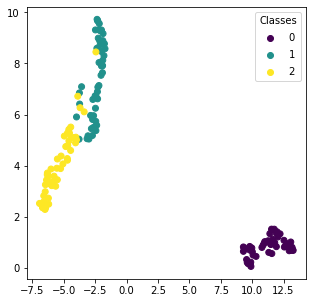

In [6]:
fig, ax = plt.subplots(figsize=(5,5))
scatter = ax.scatter(embedding[:,0],embedding[:,1],c=y)
legend1 = ax.legend(*scatter.legend_elements(),title="Classes")

In [60]:
def eval_score_sum(vector1,vector2):
        diff = np.abs(vector1 - vector2)
        score = np.around(np.sum(diff),3)
        return score

def umap_shap(batch1, batch2, y_1, y_2, emb1, emb2):
    fs = 28
    Combined = np.vstack((batch1, batch2))
    embedding = np.vstack((emb1, emb2))
    # Initial Visualization per label
    seurat_labels = list(y_1) + list(y_2)
    unq_labels = np.unique(seurat_labels)
    fig, axs = plt.subplots(1,3, figsize=(10, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)

    axs = axs.ravel()

    for label in unq_labels:
        tmp_ctrl=emb1[y_1 == label,:]
        tmp_stim=emb2[y_2 == label,:]

        axs[label].scatter(tmp_ctrl[:,0],tmp_ctrl[:,1],s=5,alpha=0.6)
        axs[label].scatter(tmp_stim[:,0],tmp_stim[:,1],s=5,alpha=0.6,c='r')
        axs[label].set_title('label {}'.format(label))
        
    # XGBoost
    X = Combined
    y0 = embedding[:,0]

    model_x = XGBRegressor()
    model_x.fit(X, y0)

    predicted_x = model_x.predict(X)

    y1 = embedding[:,1]

    model_y = XGBRegressor()
    model_y.fit(X, y1)
    predicted_y = model_y.predict(X)

    plt.figure(figsize=(3,3))
    plt.scatter(y0,y1,s=10)
    plt.scatter(predicted_x,predicted_y,c='r',s=5)
    
    # SHAP
    explainer = shap.TreeExplainer(model_x,X)
    shap_value_x = explainer.shap_values(X)
    explainer = shap.TreeExplainer(model_y,X)
    shap_value_y = explainer.shap_values(X)
    
    comb_shap_values = np.sqrt((shap_value_x**2 + shap_value_y**2))
    batch1_shap = comb_shap_values[:len(y_1),:]
    batch2_shap = comb_shap_values[len(y_1):,:]
    
    # Analysis
    cell_num = []
    for label in unq_labels:
        a=np.sum(y_1 == label)
        b=np.sum(y_2 == label)
        cell_num.append(min(a,b))
        
    cell_orders = unq_labels[np.argsort(-1*np.array(cell_num))]
    
    # Cell-type variation
    fig, axs = plt.subplots(1,3, dpi=300, figsize=(10,3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.25)
    axs = axs.ravel()
    scores_stunst1 = []
    for ct,label in enumerate(cell_orders):
        tmp_batch1_shap = batch1_shap[y_1 == label, :]
        tmp_batch2_shap = batch2_shap[y_2 == label, :]

        tmp_mean_feature1 = np.mean(tmp_batch1_shap,axis=0)
        tmp_mean_feature2 = np.mean(tmp_batch2_shap,axis=0)
        
        score = eval_score_sum(tmp_mean_feature1, tmp_mean_feature2)
        scores_stunst1.append(score)
        cap = max(np.max(tmp_mean_feature1), np.max(tmp_mean_feature2)) + 0.3
        diag = np.linspace(0,cap)
        axs[ct].scatter(tmp_mean_feature1,tmp_mean_feature2)
        axs[ct].plot(diag,diag)
        axs[ct].set_xlim(0,cap)
        axs[ct].set_ylim(0,cap)
        axs[ct].set_title('label ' + str(label)+'\n' + str(score),fontsize=fs)
        
    # Random Variation
    comb_label = list(y_1)+list(y_2)
    LABEL_SCORES_COMB = []
    for label in cell_orders:
        label_score = []
        for i in range(10000):

            tmp_batch = comb_shap_values[np.array(comb_label) == label, :]

            tmp_batch1_shap = tmp_batch[np.random.randint(0, tmp_batch.shape[0],int(tmp_batch.shape[0]/2)),:]
            tmp_batch2_shap = tmp_batch[np.random.randint(0, tmp_batch.shape[0],int(tmp_batch.shape[0]/2)),:]

            tmp_mean_feature1 = np.mean(tmp_batch1_shap,axis=0)
            tmp_mean_feature2 = np.mean(tmp_batch2_shap,axis=0)

            score = eval_score_sum(tmp_mean_feature1, tmp_mean_feature2)
            label_score.append(score)
        LABEL_SCORES_COMB.append(label_score)
        
    ct = 0
    
    # Showing the variation with cell-specific scores 
    fig, axs = plt.subplots(1,3, dpi=300, figsize=(10,3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.25)
    axs = axs.ravel()

    for scores in LABEL_SCORES_COMB:
        axs[ct].hist(scores)
        tmp = scores + [scores_stunst1[ct]]
        zscores = stats.zscore(tmp)
        p_values = 1 - scipy.special.ndtr(zscores)
        axs[ct].set_title('label {} \n p_val:{}'.format(cell_orders[ct],str(p_values[-1])[:5]),fontsize=fs)
        axs[ct].axvline(scores_stunst1[ct], color='r', linestyle='dashed', linewidth=3)
        axs[ct].set_xlim([min(scores),scores_stunst1[ct] + 1])
        ct += 1
        
    mean_perms = []
    for scores in LABEL_SCORES_COMB:
        mean_perms.append(np.nanmean(scores))

    # Cell-type variation random-perm corrected
    fig, axs = plt.subplots(1,3, dpi=300, figsize=(10,3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.25)
    axs = axs.ravel()
    scores_stunst1 = []
    corrected_scores = []
    for ct,label in enumerate(cell_orders):
        tmp_batch1_shap = batch1_shap[y_1 == label, :]
        tmp_batch2_shap = batch2_shap[y_2 == label, :]

        tmp_mean_feature1 = np.mean(tmp_batch1_shap,axis=0)
        tmp_mean_feature2 = np.mean(tmp_batch2_shap,axis=0)

        score = eval_score_sum(tmp_mean_feature1, tmp_mean_feature2)
        scores_stunst1.append(score)
        cap = max(np.max(tmp_mean_feature1), np.max(tmp_mean_feature2)) + 0.3
        diag = np.linspace(0,cap)
        print(tmp_mean_feature1.shape)
        for q in range(4):
            axs[ct].scatter(tmp_mean_feature1[q],tmp_mean_feature2[q])
        axs[ct].legend(feature_names,loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True)
        
        axs[ct].plot(diag,diag)
        axs[ct].set_xlim(0,cap)
        axs[ct].set_ylim(0,cap)
        axs[ct].set_title('label ' + str(label)+'\n' +  str(np.round(score-mean_perms[ct],2)),fontsize=fs)
        corrected_scores.append(score-mean_perms[ct])
        
    # Featuer Scores 
    scores = []
    gene_ranks = []
    gene_ranks_pd = []
    gene_ranks_scores = []
    GENE_SCORES = []
    GENE_SCORES2 = []
    for label in unq_labels:
        tmp_batch1_shap = batch1_shap[y_1 == label, :]
        tmp_batch2_shap = batch2_shap[y_2 == label, :]
        tmp_combined_shap = np.vstack((tmp_batch1_shap,tmp_batch2_shap))

        tmp_mean_feature1 = np.mean(tmp_batch1_shap,axis=0)
        tmp_mean_feature2 = np.mean(tmp_batch2_shap,axis=0)
        diag = np.linspace(0,np.max(np.concatenate([tmp_mean_feature1, tmp_mean_feature2])))
        
        score_by_feat = eval_score_sum(tmp_mean_feature1, tmp_mean_feature2)
        scores.append(score_by_feat)
        gene_scores = np.abs(tmp_mean_feature1 - tmp_mean_feature2)
        gene_scores2 = (np.abs(tmp_mean_feature1 - tmp_mean_feature2)) / ((tmp_mean_feature1 + tmp_mean_feature2)/2)
        GENE_SCORES.append(gene_scores)
        GENE_SCORES2.append(gene_scores2)
        gene_ranks_pd.append(np.array(feature_names)[np.argsort(-1*(np.abs(tmp_mean_feature1 - tmp_mean_feature2)))])
        gene_ranks_scores.append(gene_scores[np.argsort(-1*(np.abs(tmp_mean_feature1 - tmp_mean_feature2)))])
        gene_ranks.append(np.array(feature_names)[np.argsort(np.abs(tmp_mean_feature1 - tmp_mean_feature2))])
    
    GS = pd.DataFrame(GENE_SCORES,columns=feature_names)
    GS2 = pd.DataFrame(GENE_SCORES2,columns=feature_names)
        
    gene_meta_ranks = []
    for gene in feature_names:
        gene_loc = []
        for rank in gene_ranks:
            gene_loc.append(np.where(rank == gene)[0][0])
        gene_meta_ranks.append(gene_loc)
    gene_meta_ranks = np.array(gene_meta_ranks)
    
    csv = []
    for i in range(len(gene_ranks_pd)):
        csv.append(gene_ranks_pd[i])
        csv.append(gene_ranks_scores[i])

    column_names = []
    for i in range(len(unq_labels)):
        column_names.append('label {}'.format(i))
        column_names.append('label {} - score'.format(i))

    diff_genes = pd.DataFrame(np.array(csv).T,columns=column_names)
    plt.show()
    
    return GS, GS2, corrected_scores

# Quantifying the Batch Effect

### SCENARIO 1 - No Batch Effect - Random Splitting 

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


(4,)
(4,)
(4,)


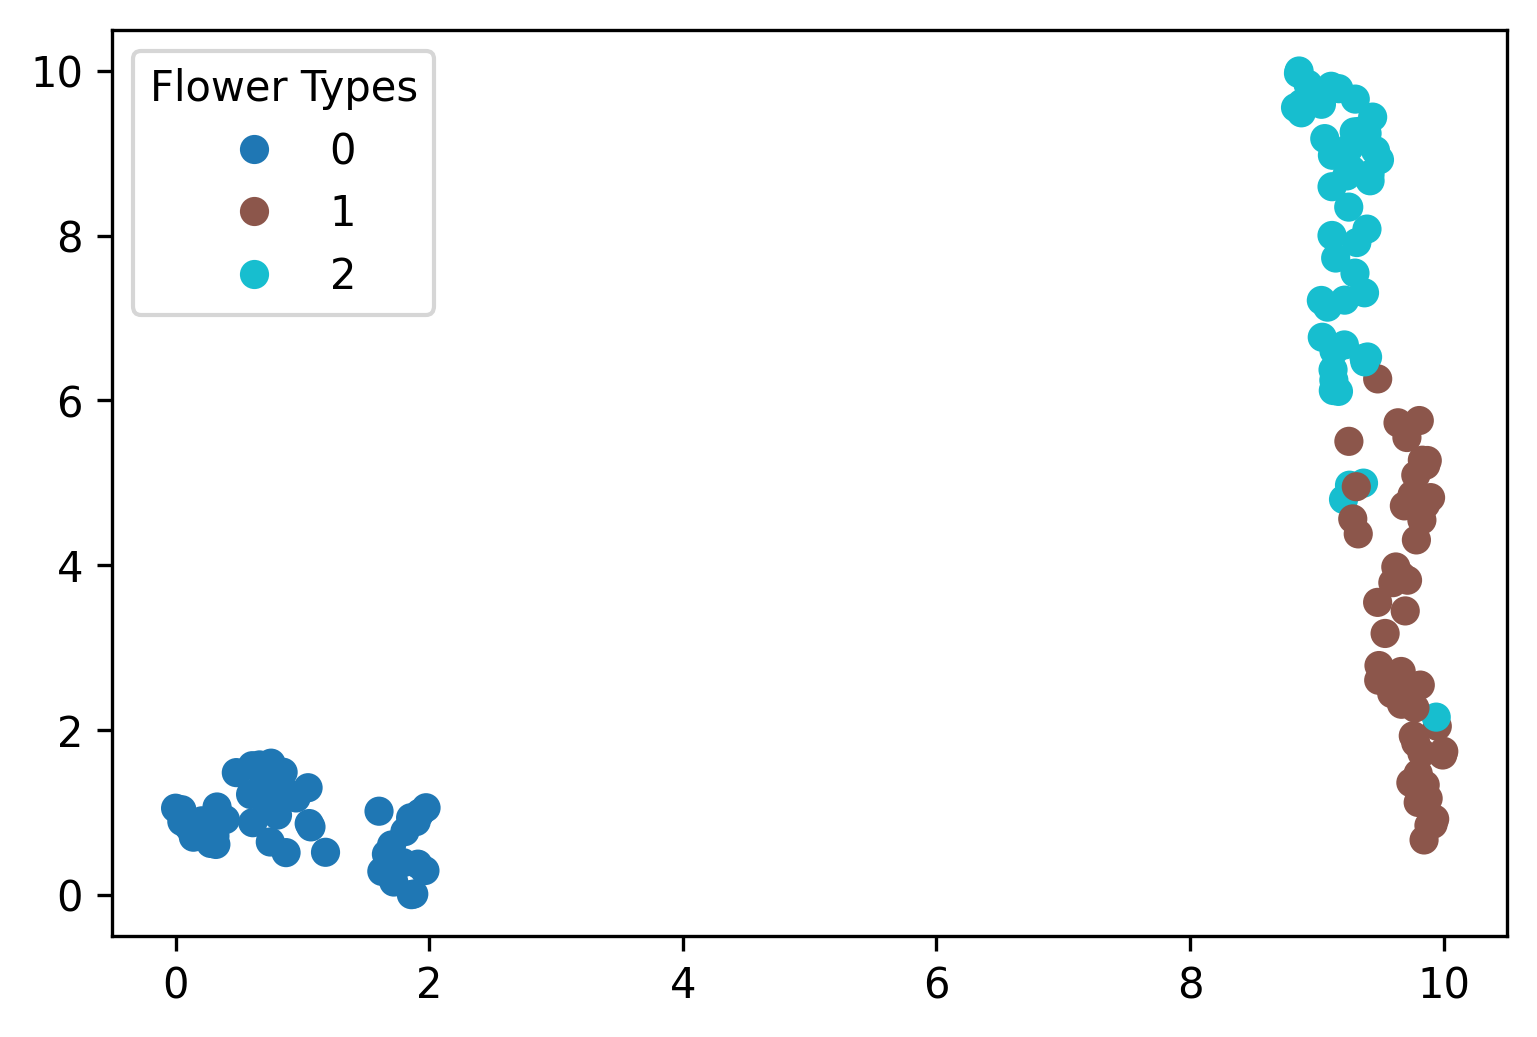

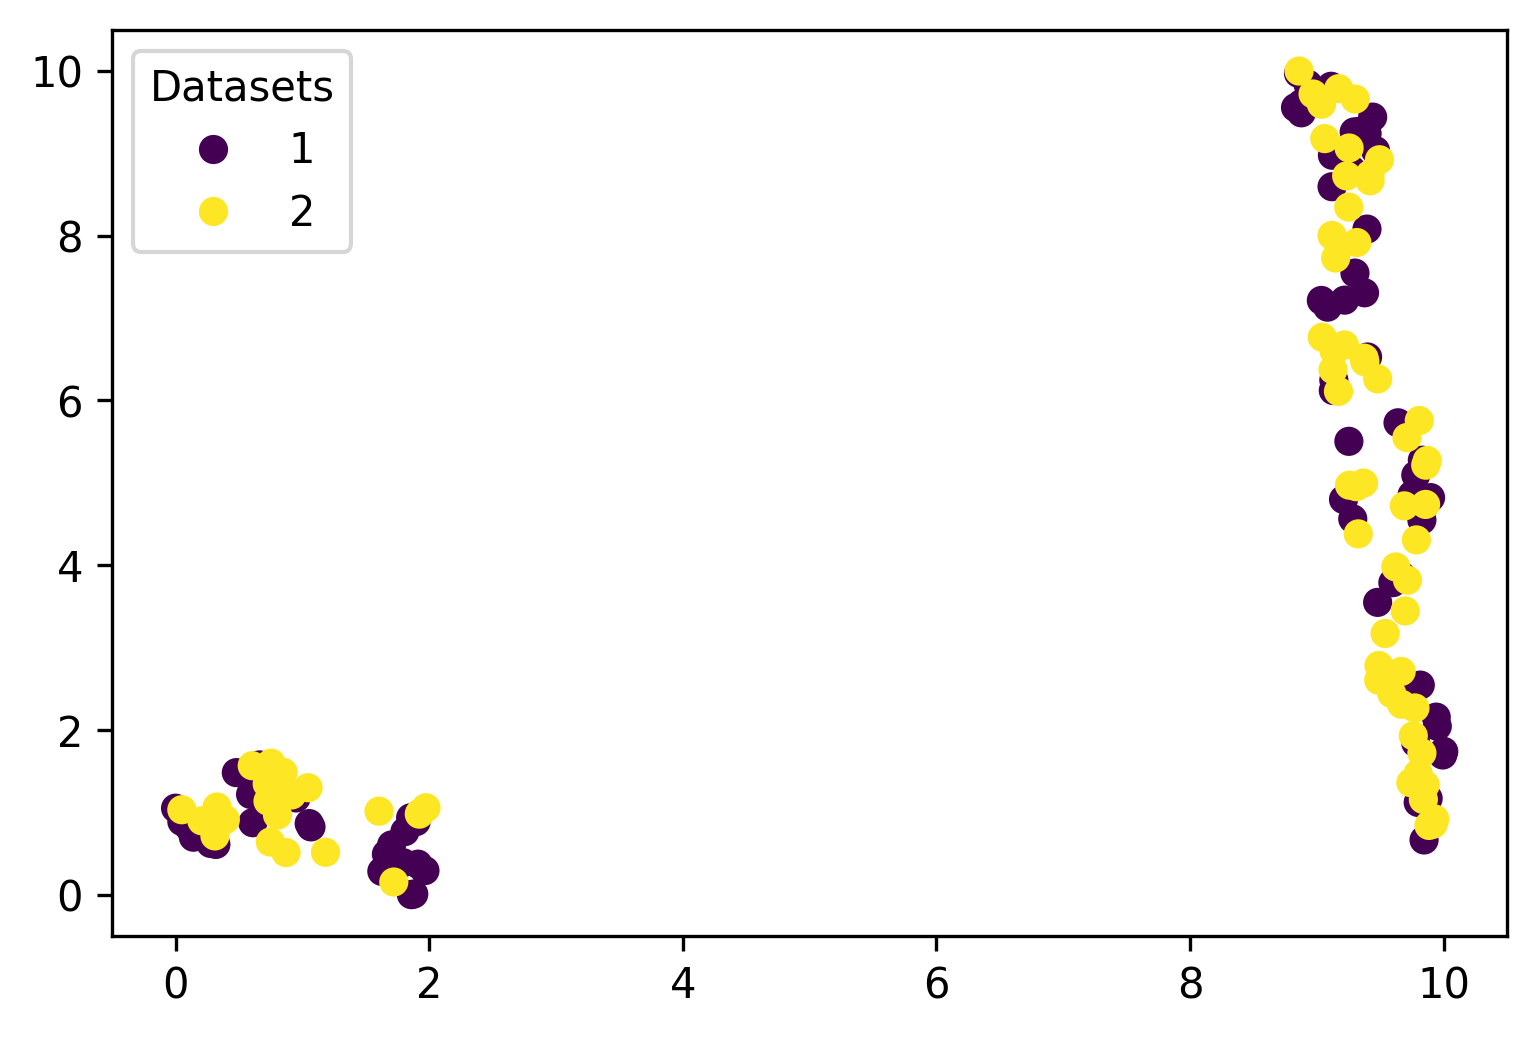

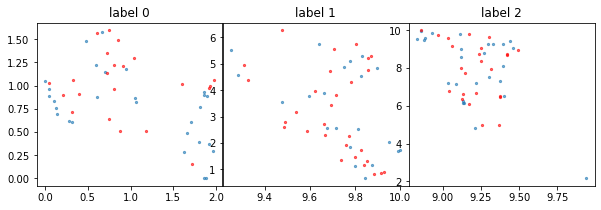

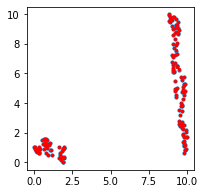

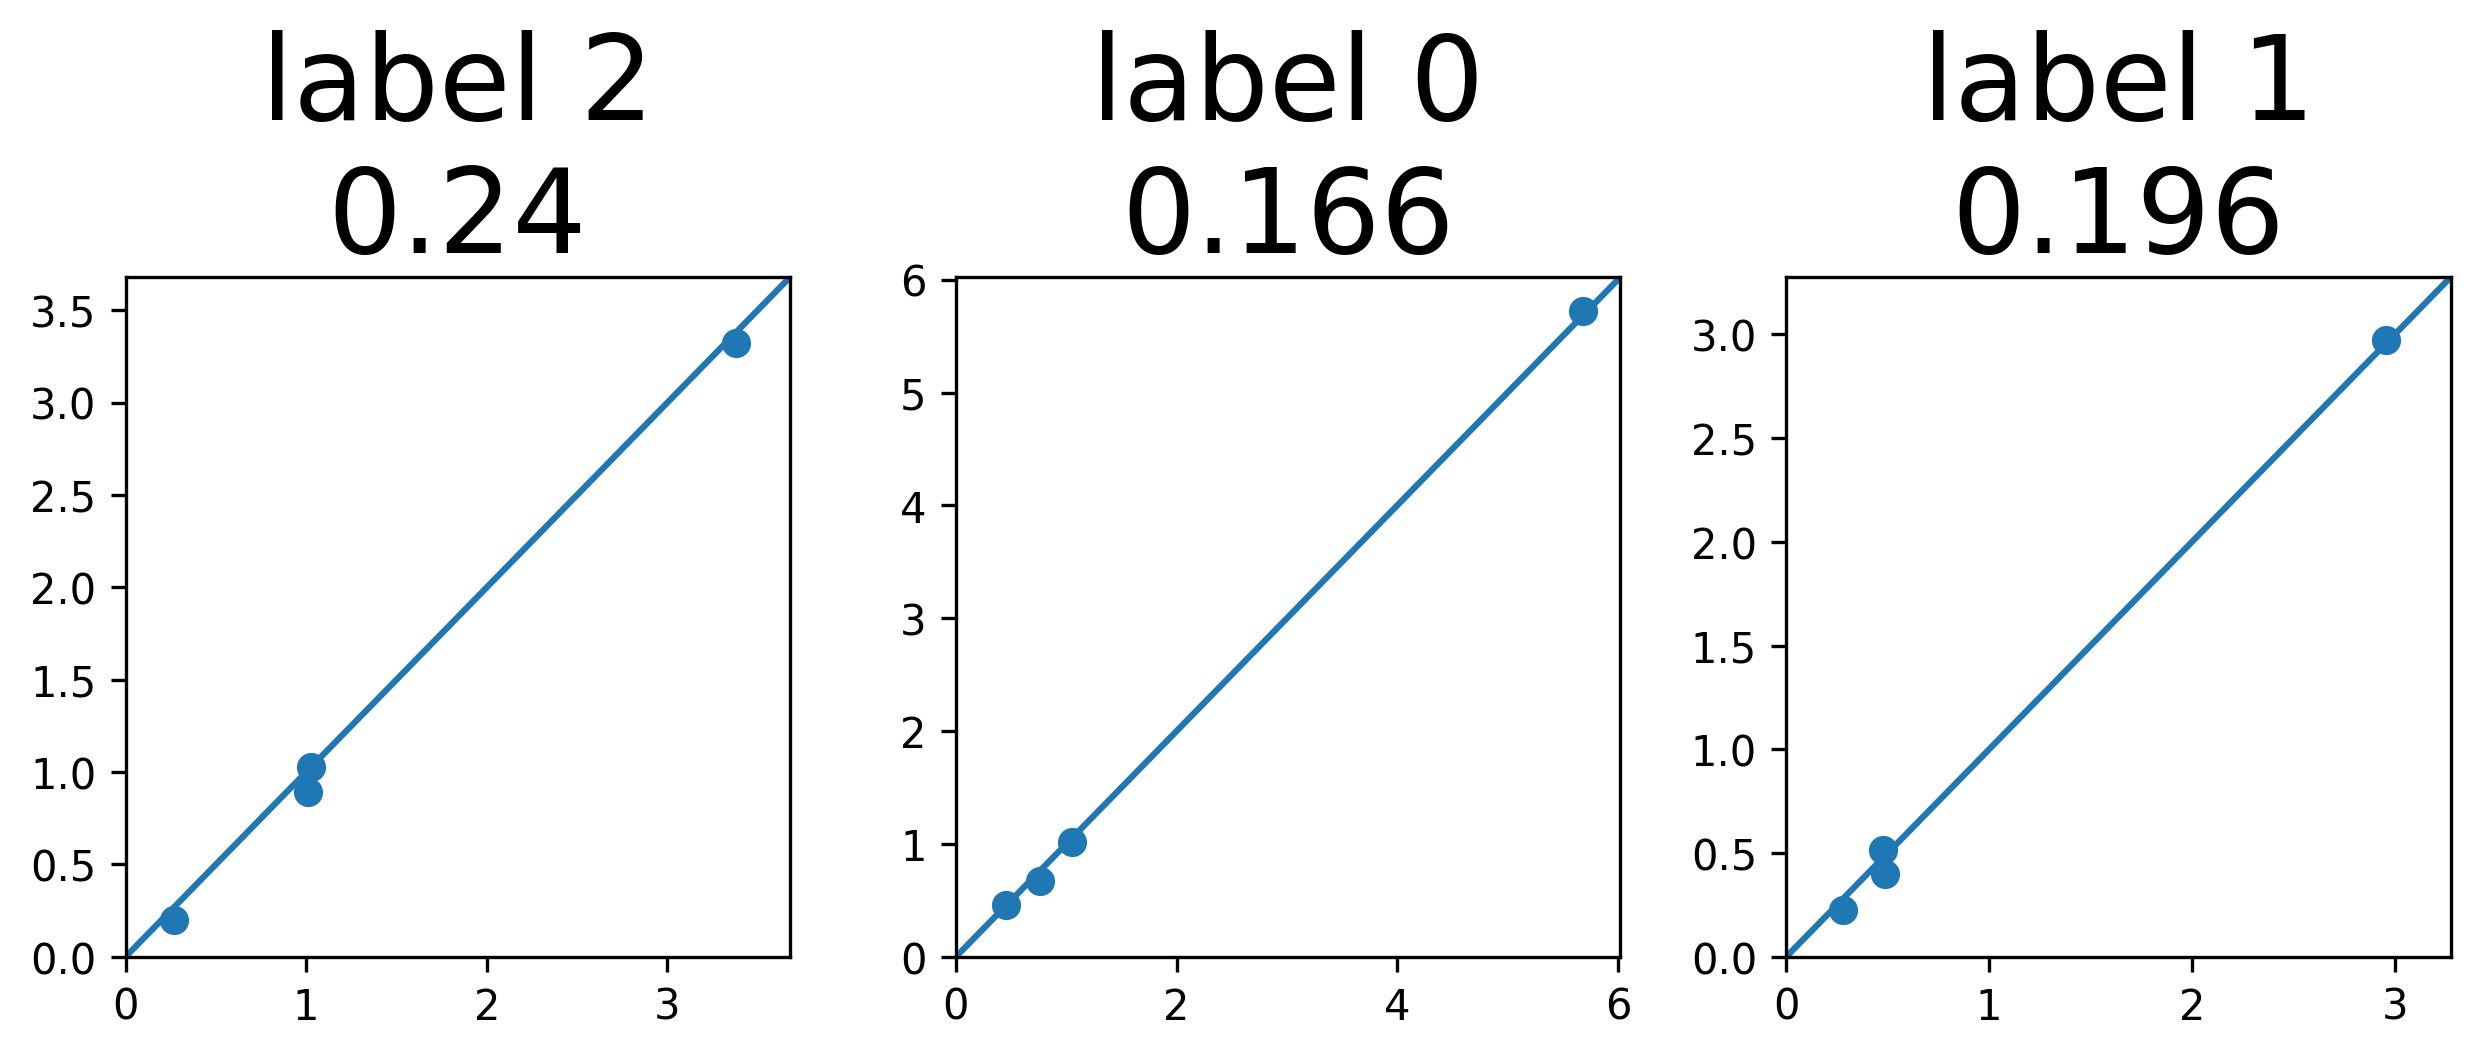

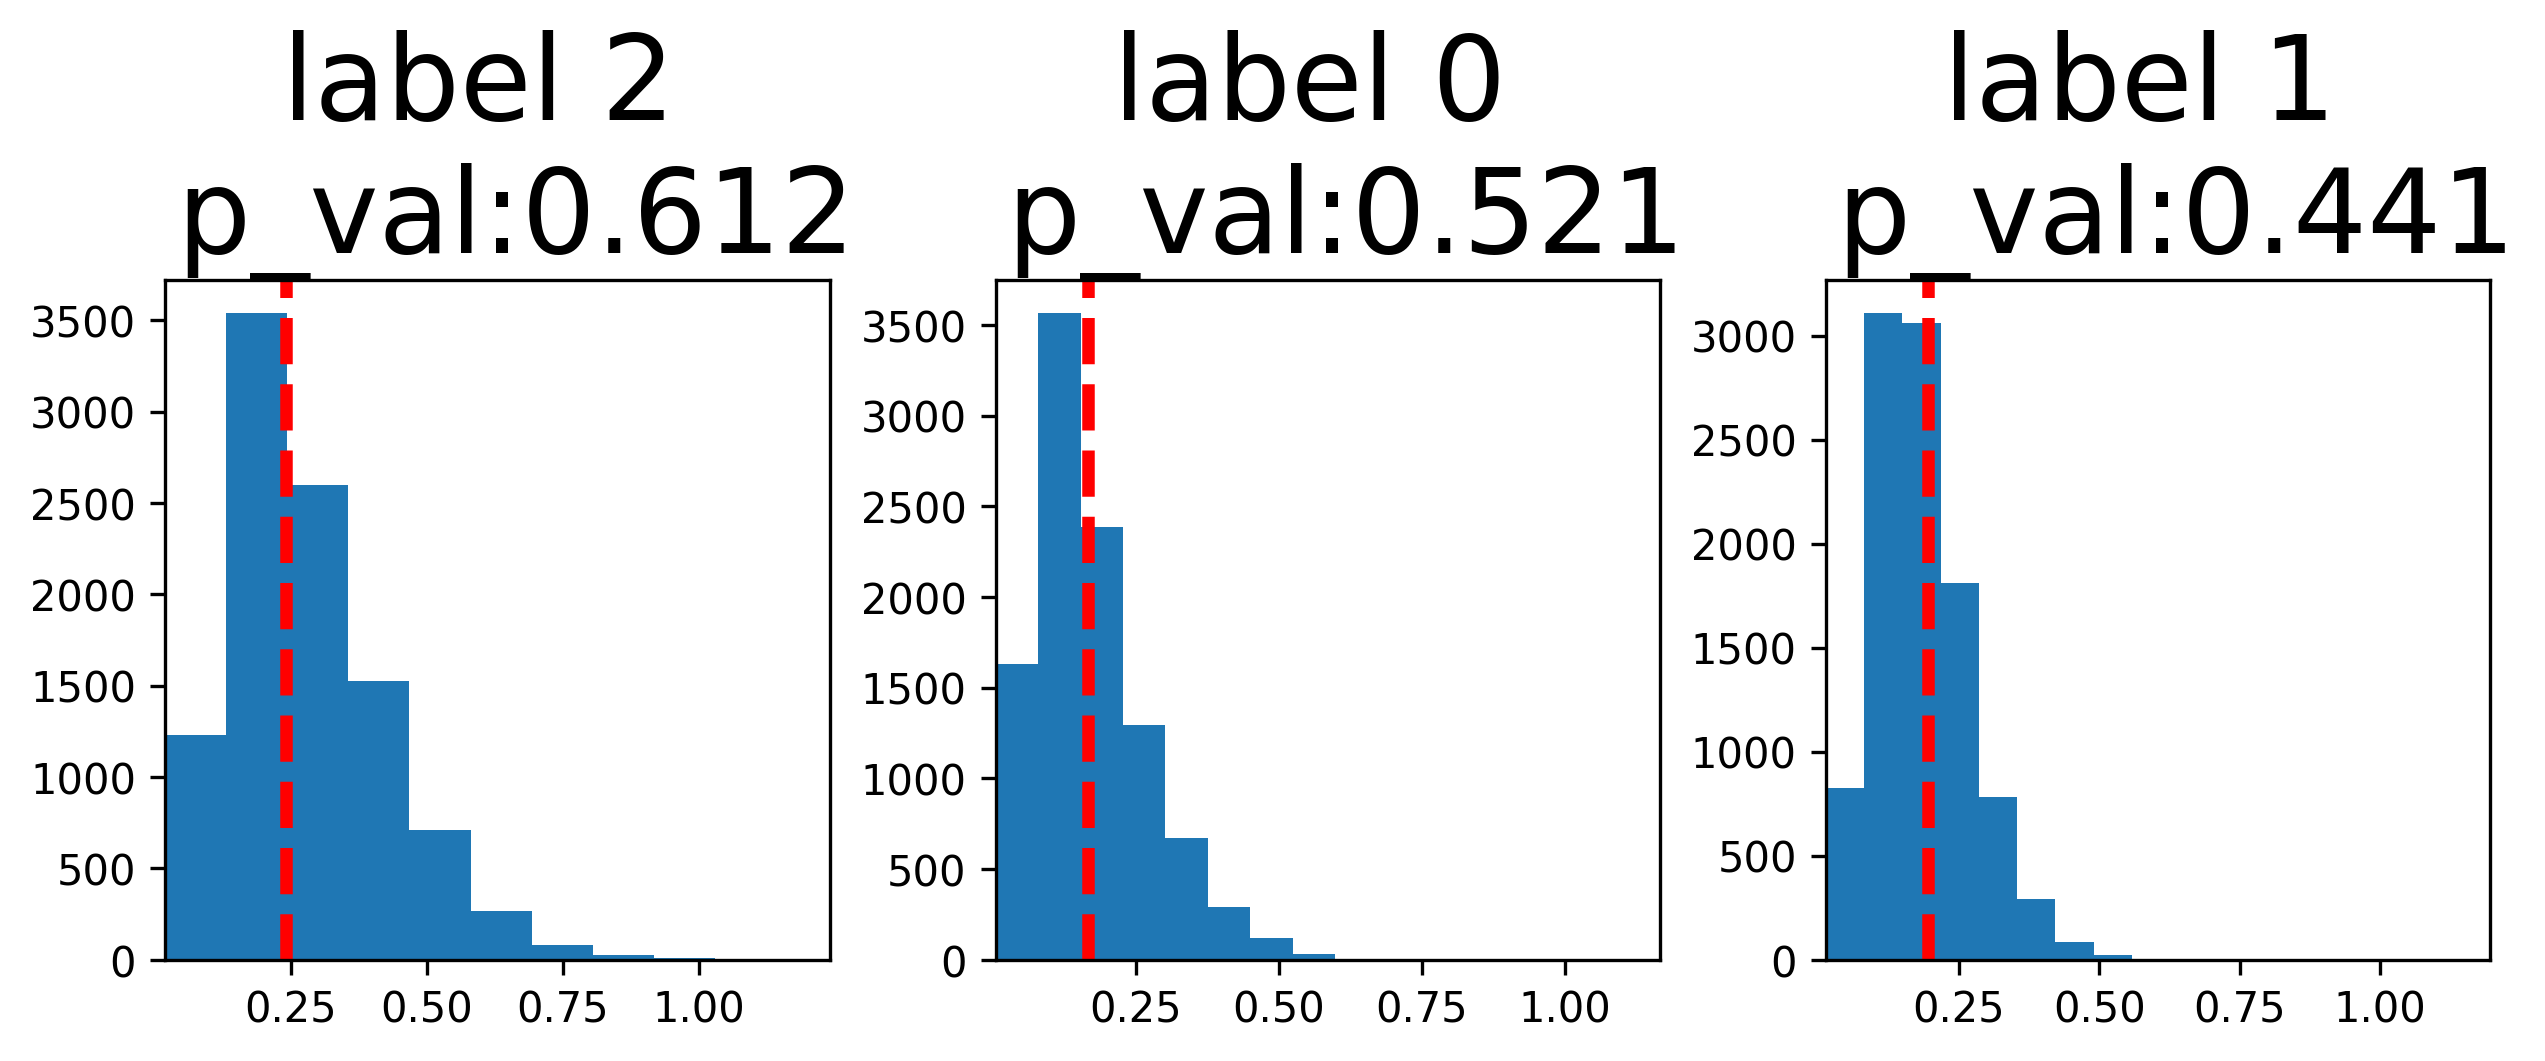

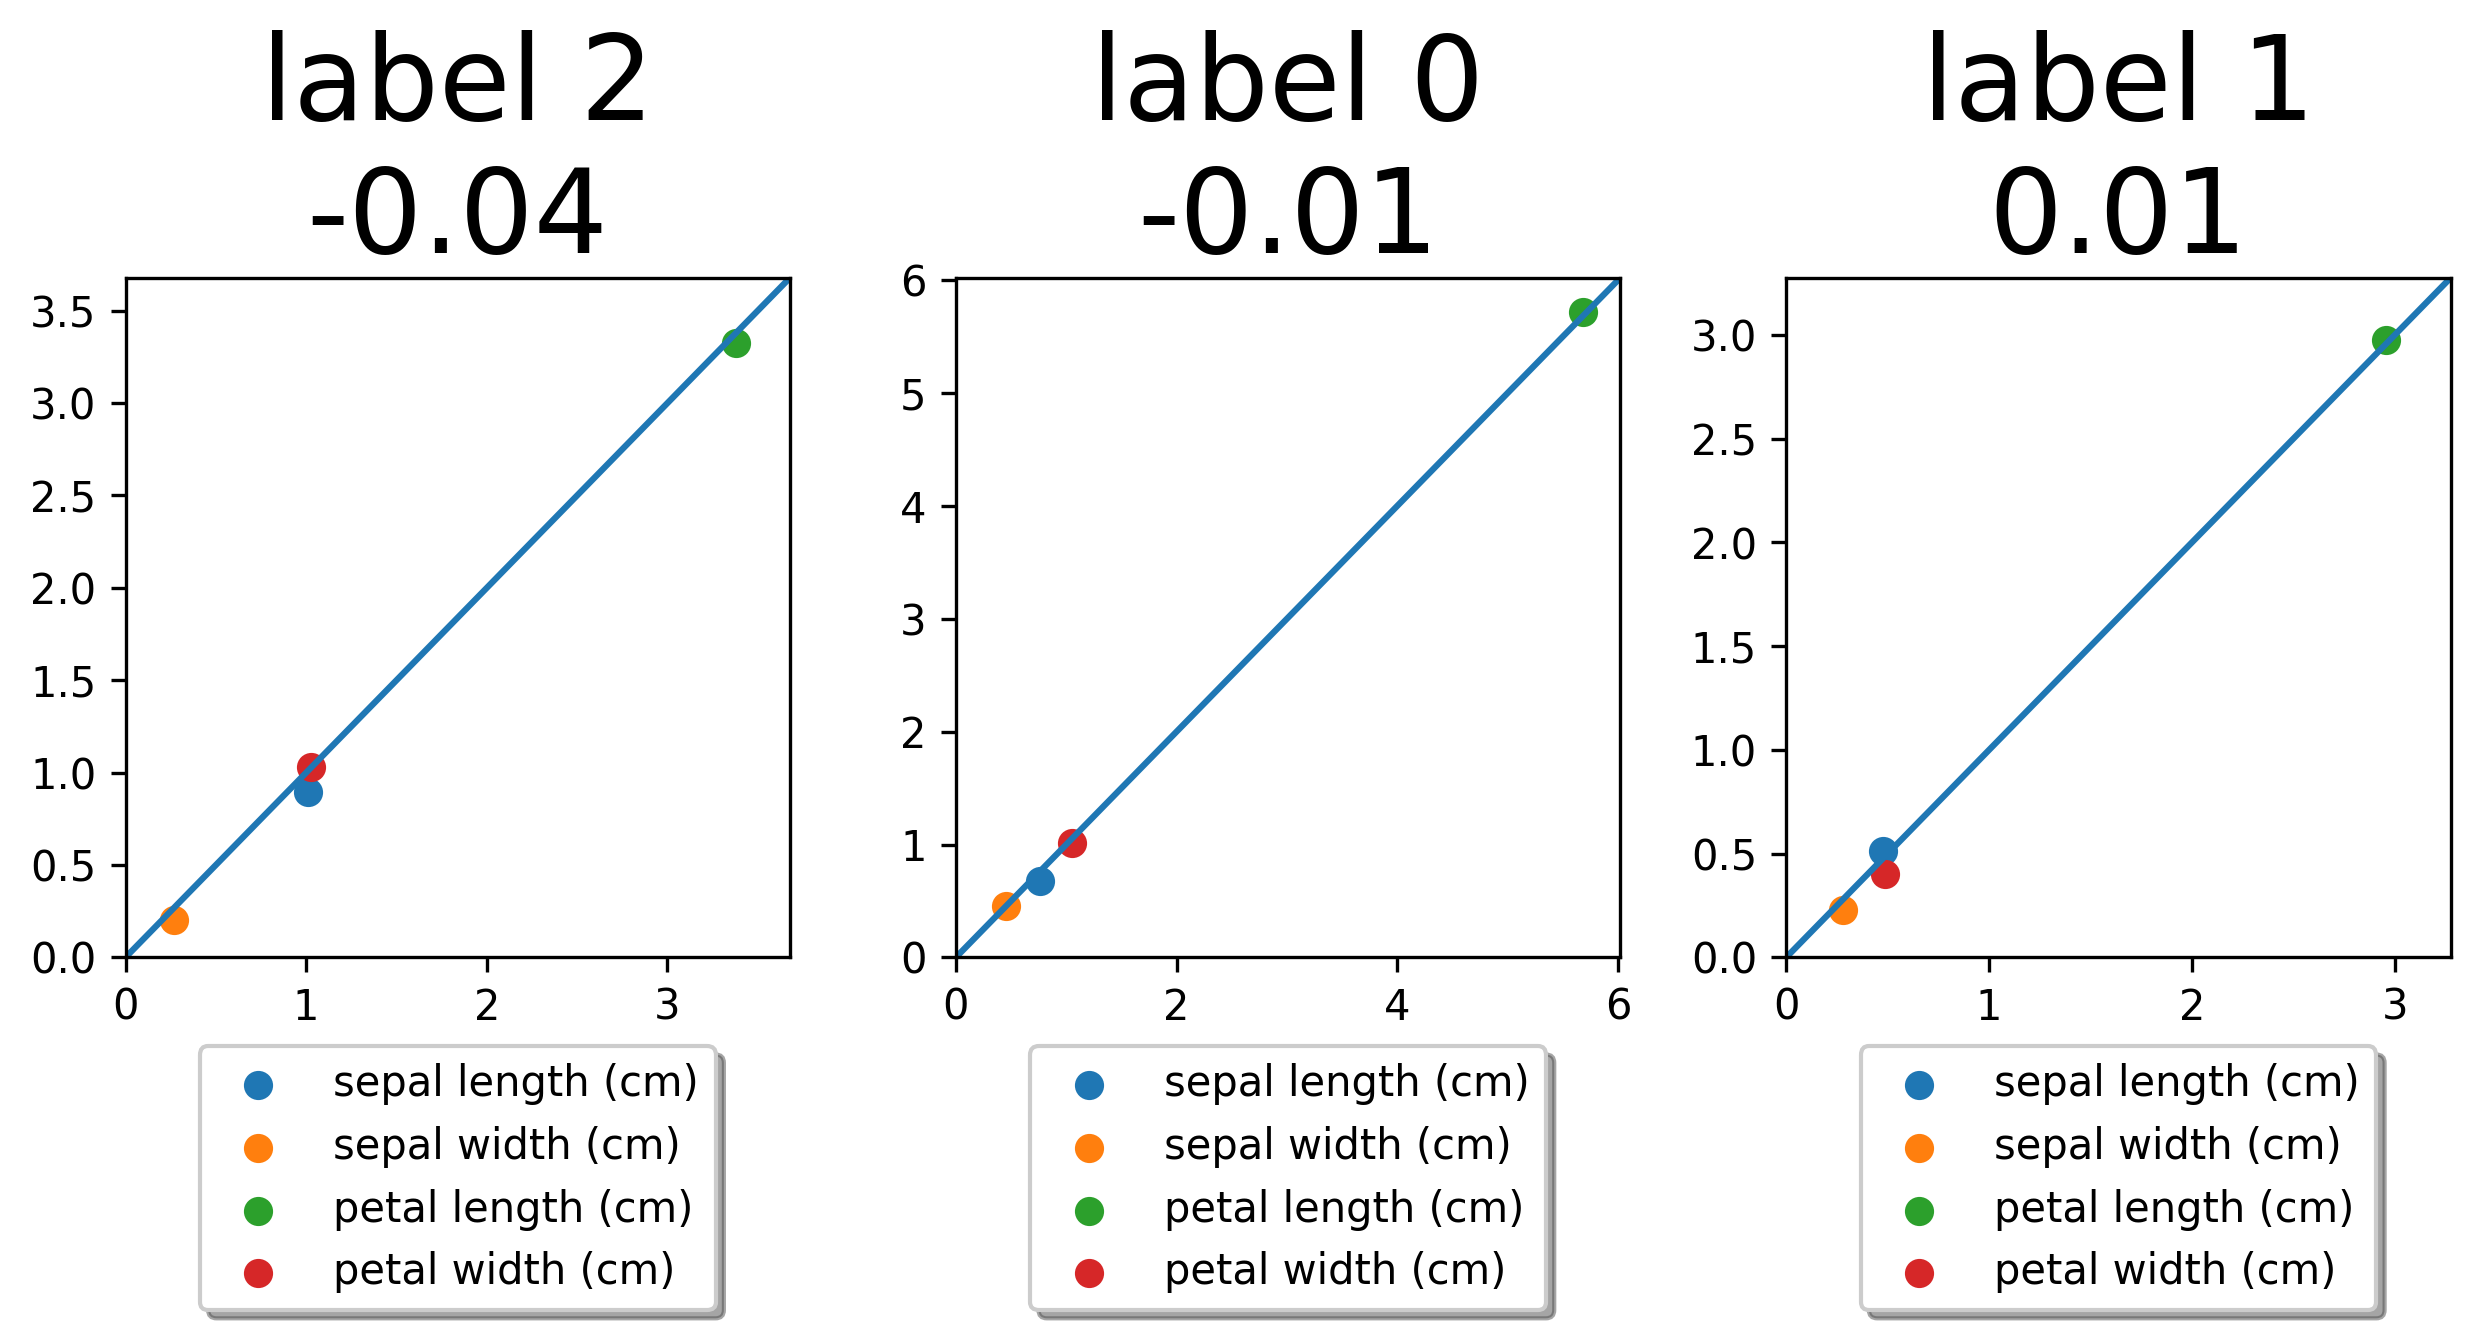

(   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
 0           0.087791          0.003309           0.034029          0.040924
 1           0.037830          0.053897           0.020098          0.084556
 2           0.115796          0.068526           0.053383          0.002212,
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
 0           0.122549          0.007255           0.005966          0.039514
 1           0.076355          0.212405           0.006778          0.190771
 2           0.121563          0.292897           0.015931          0.002152,
 [-0.04104620000000003, -0.005426900000000012, 0.012466100000000008])

In [75]:
Batch1, Batch2, y_1, y_2 = train_test_split(X, y, test_size=0.50, random_state=5)

noise_factor = 0
noise = []
for i in range(4):
    tmp = np.random.normal(noise_factor, 0.1*noise_factor, len(Batch1))
    noise.append(tmp)
noise = np.array(noise).T

Batch2 += noise

Combined = np.vstack((Batch1, Batch2))

reducer = umap.UMAP()
embedding = reducer.fit_transform(Combined)
scaler = MinMaxScaler()
embedding = 10*scaler.fit_transform(embedding)

fig, ax = plt.subplots(dpi=300)
scatter = ax.scatter(embedding[:,0],embedding[:,1],c=np.hstack((y_1,y_2)),cmap='tab10')
legend1 = ax.legend(*scatter.legend_elements(),title="Flower Types")

fig, ax = plt.subplots(dpi=300)
scatter = ax.scatter(embedding[:,0],embedding[:,1],c=np.array([0 for i in range(len(y_1))]+[1 for i in range(len(y_2))])+1)
legend1 = ax.legend(*scatter.legend_elements(),title="Datasets")

emb1 = embedding[:75,:]
emb2 = embedding[75:,:]

umap_shap(Batch1, Batch2, y_1, y_2, emb1, emb2)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


(4,)
(4,)
(4,)


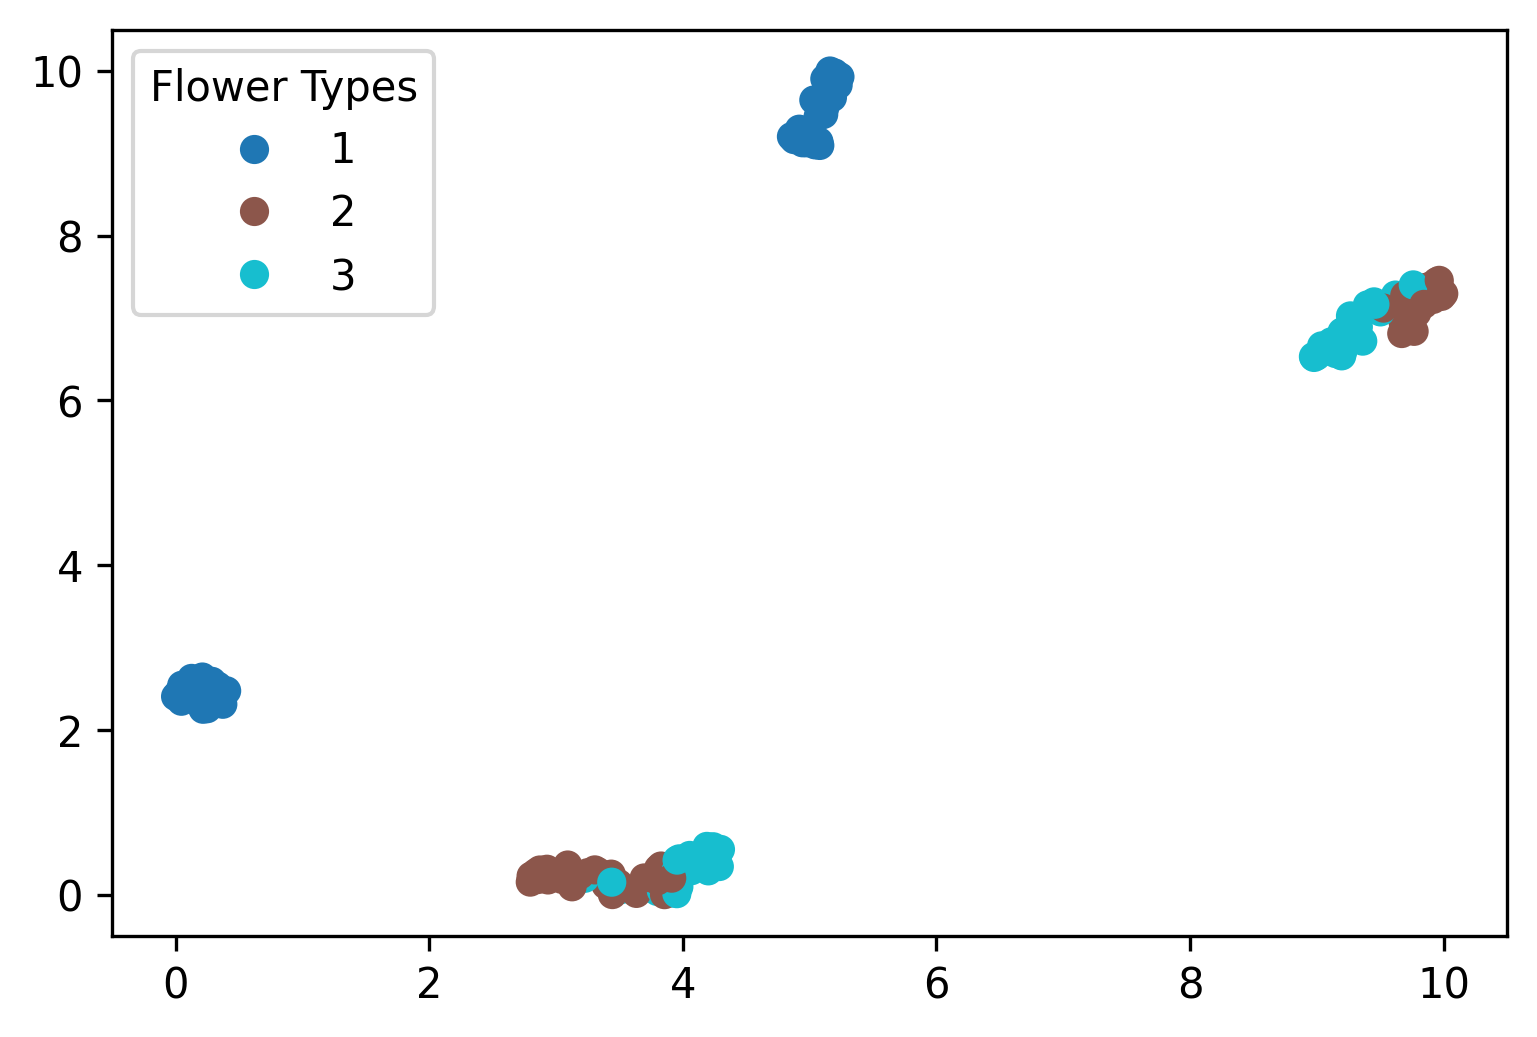

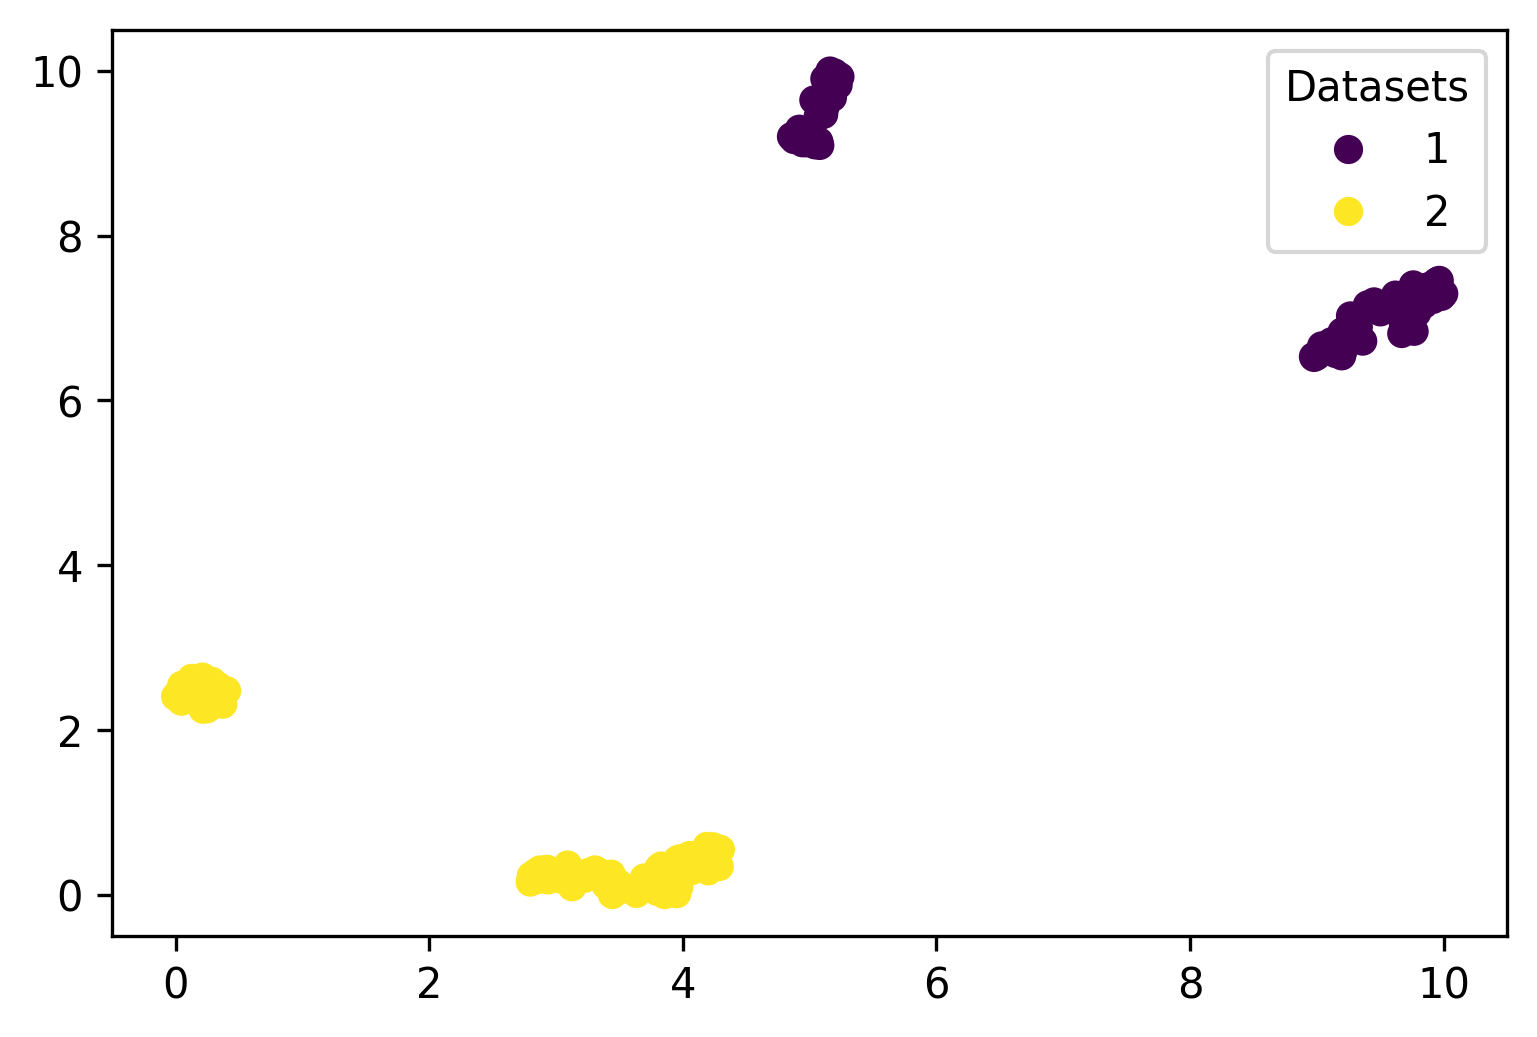

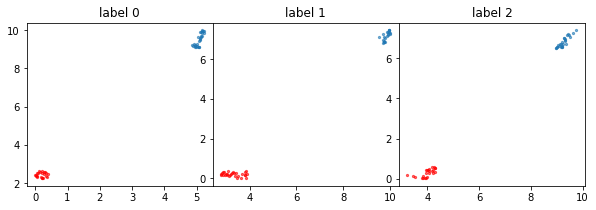

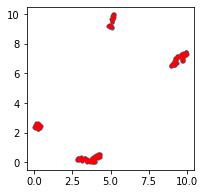

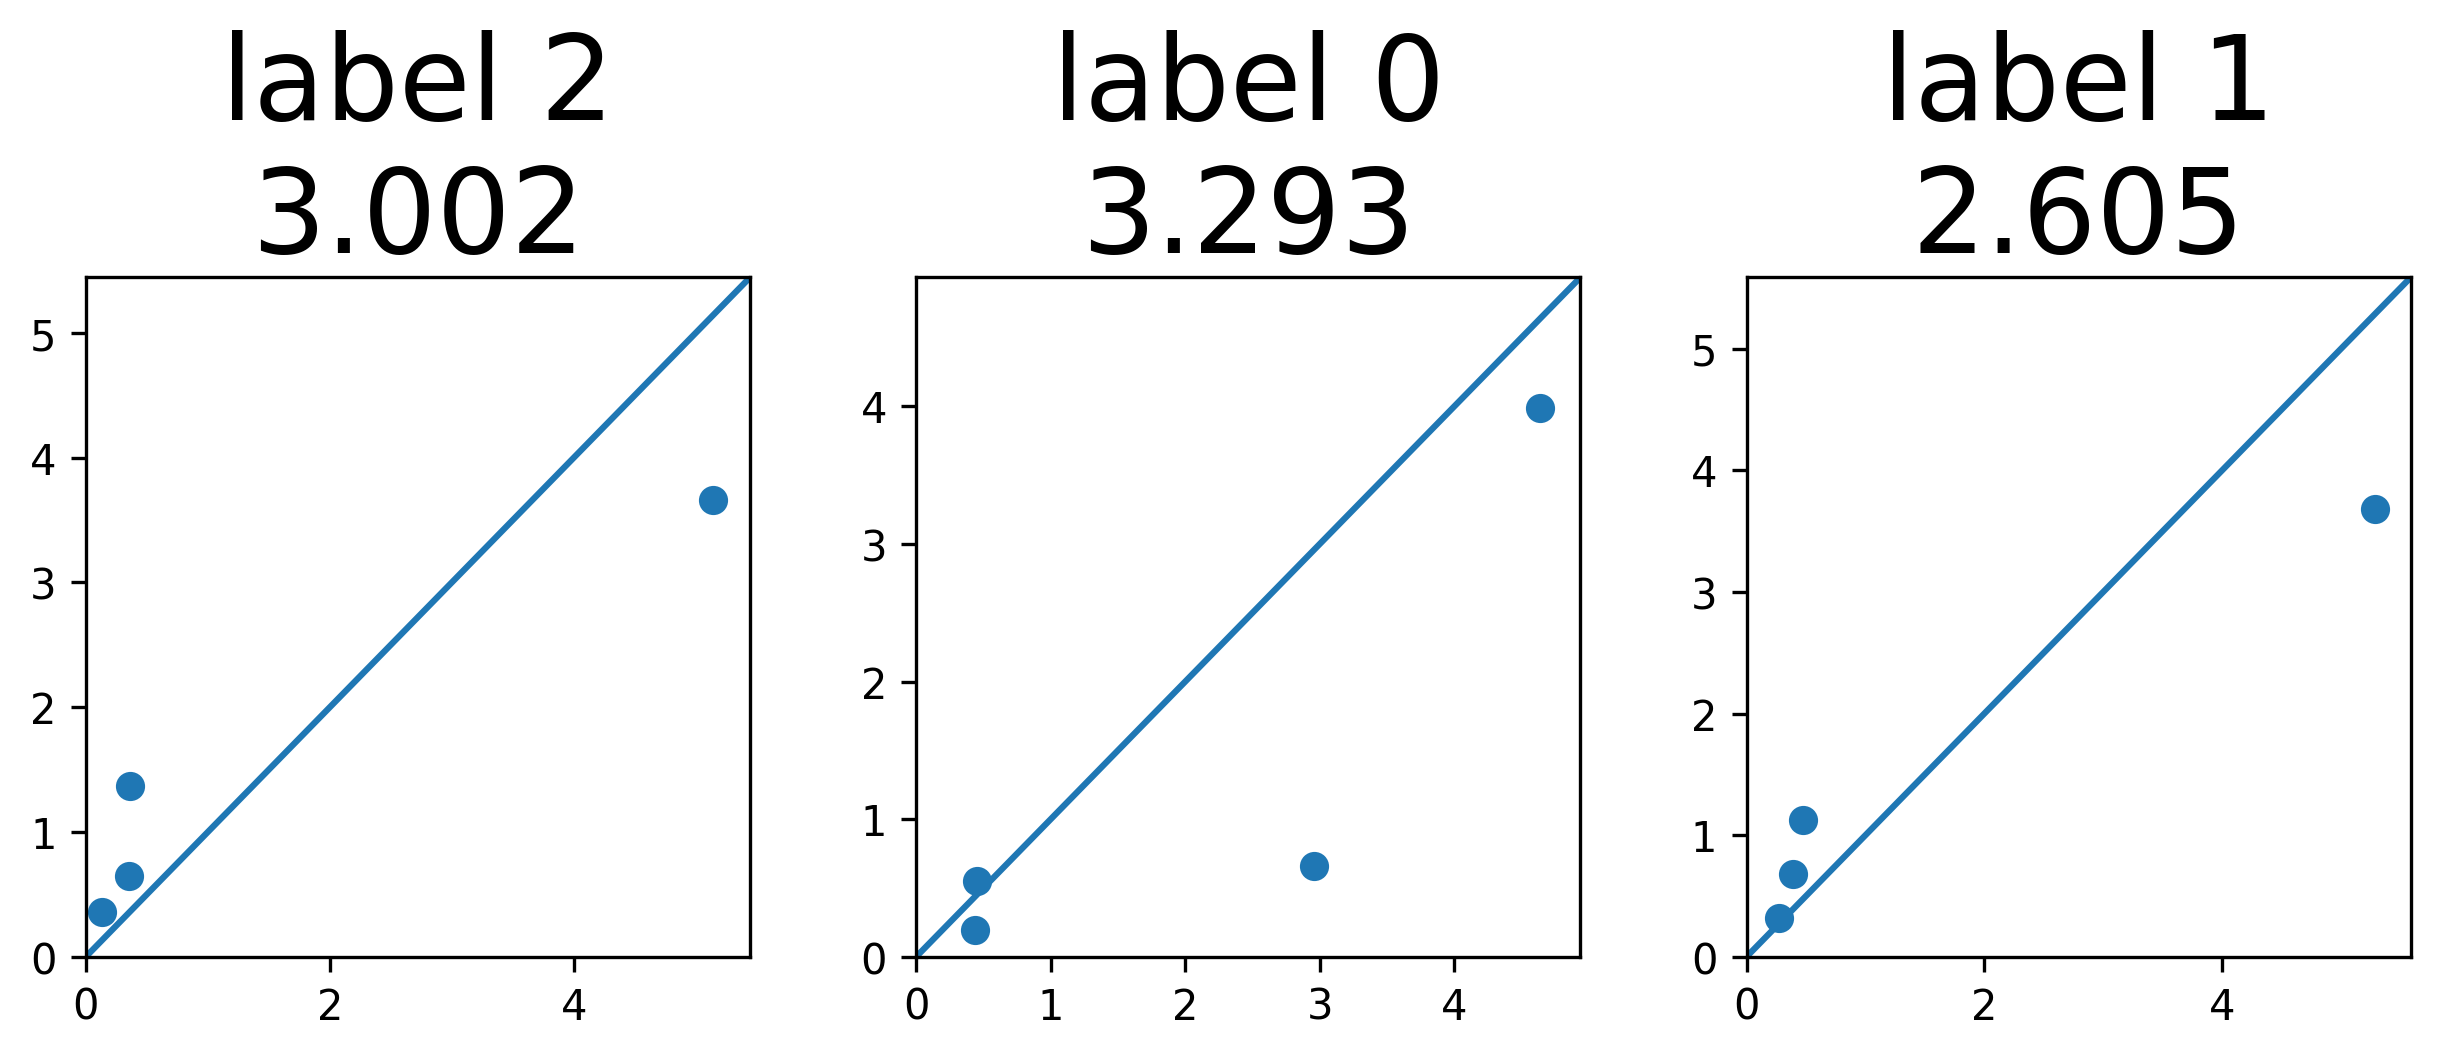

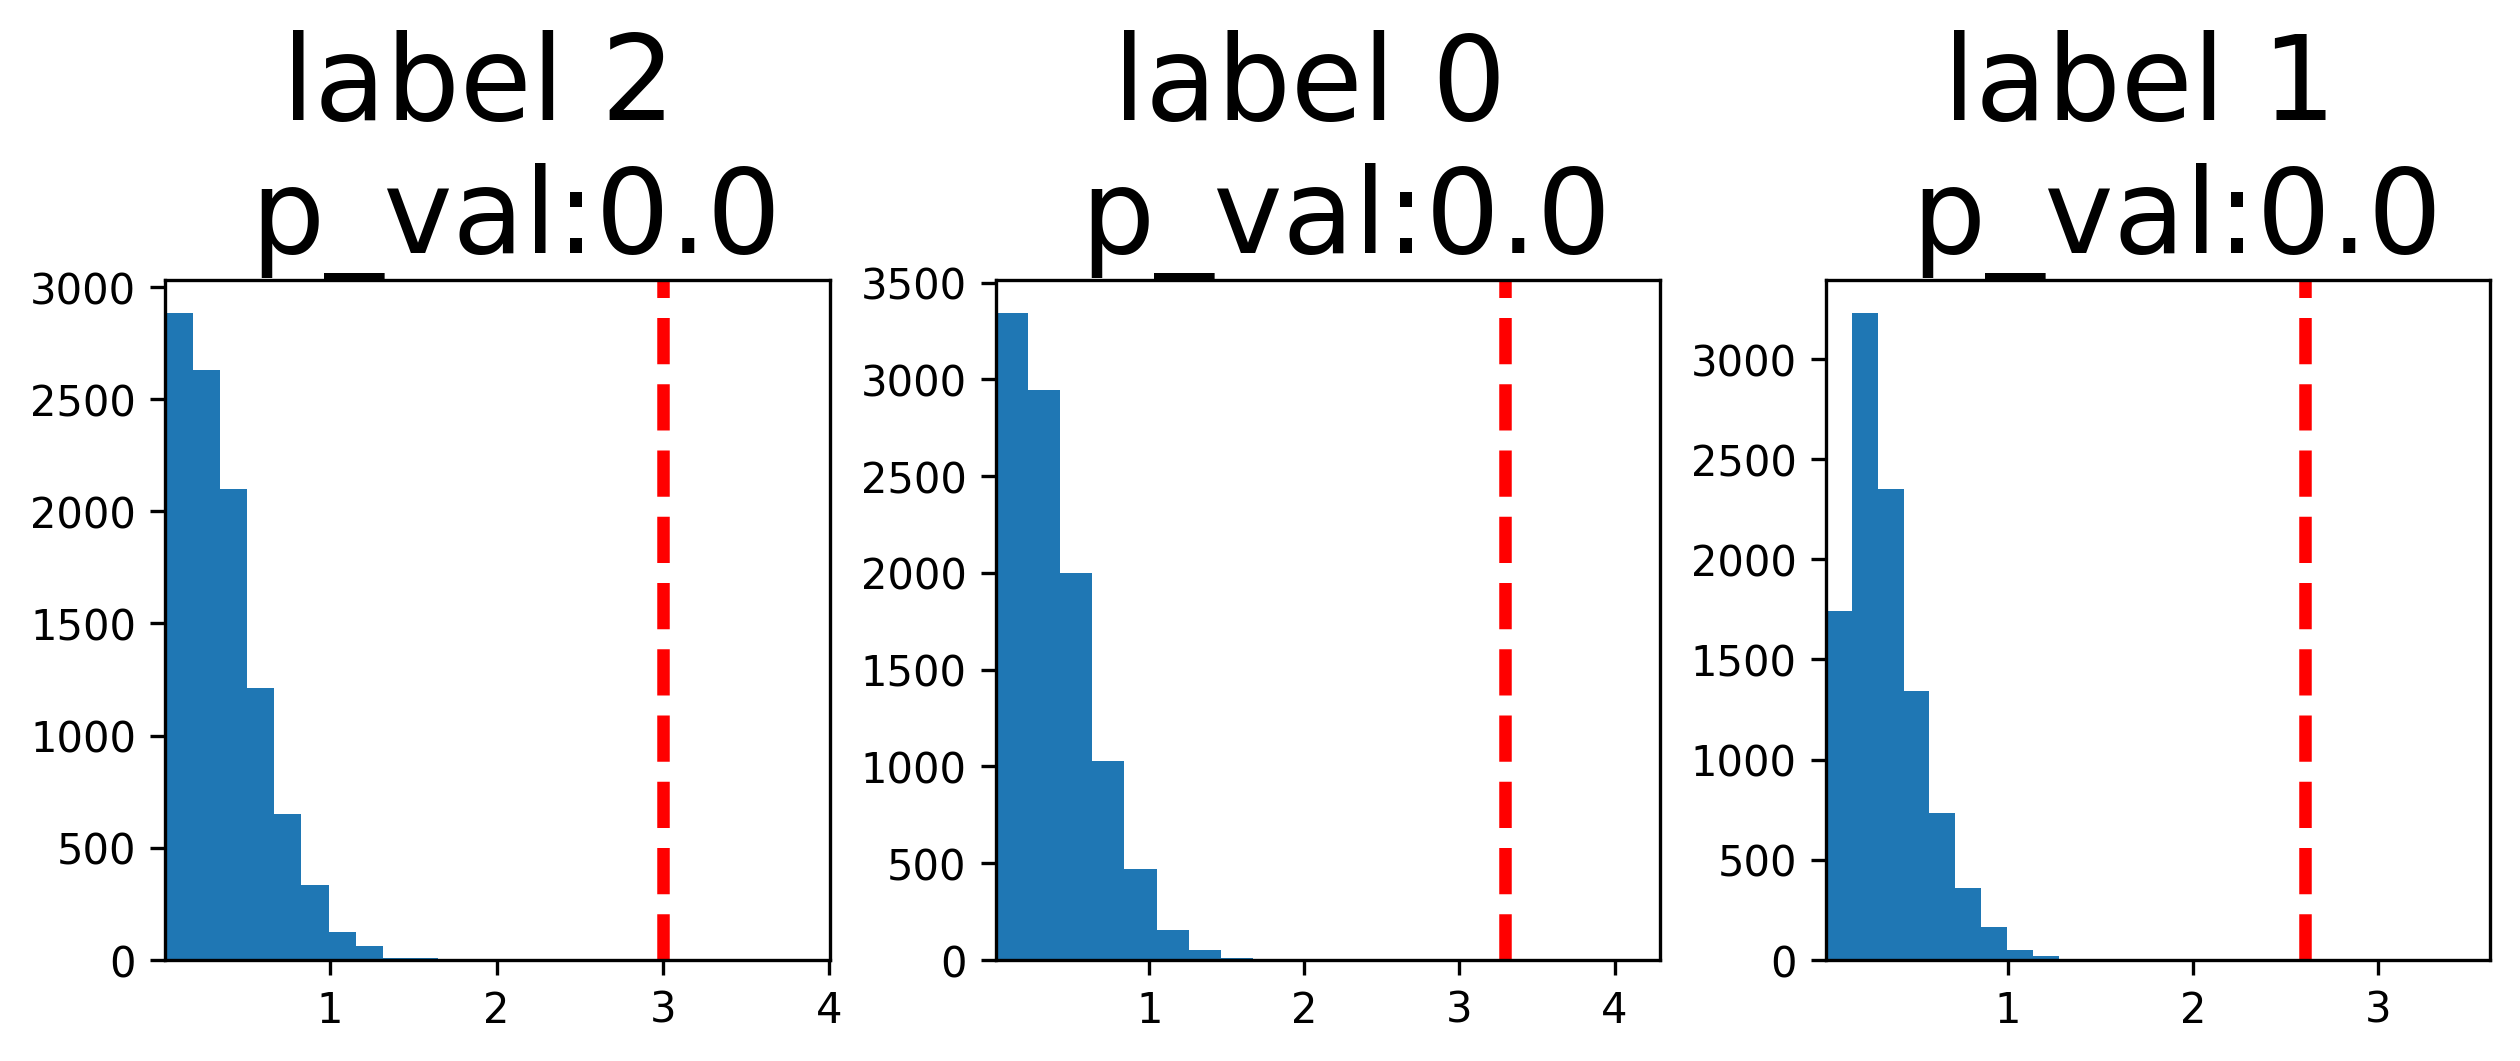

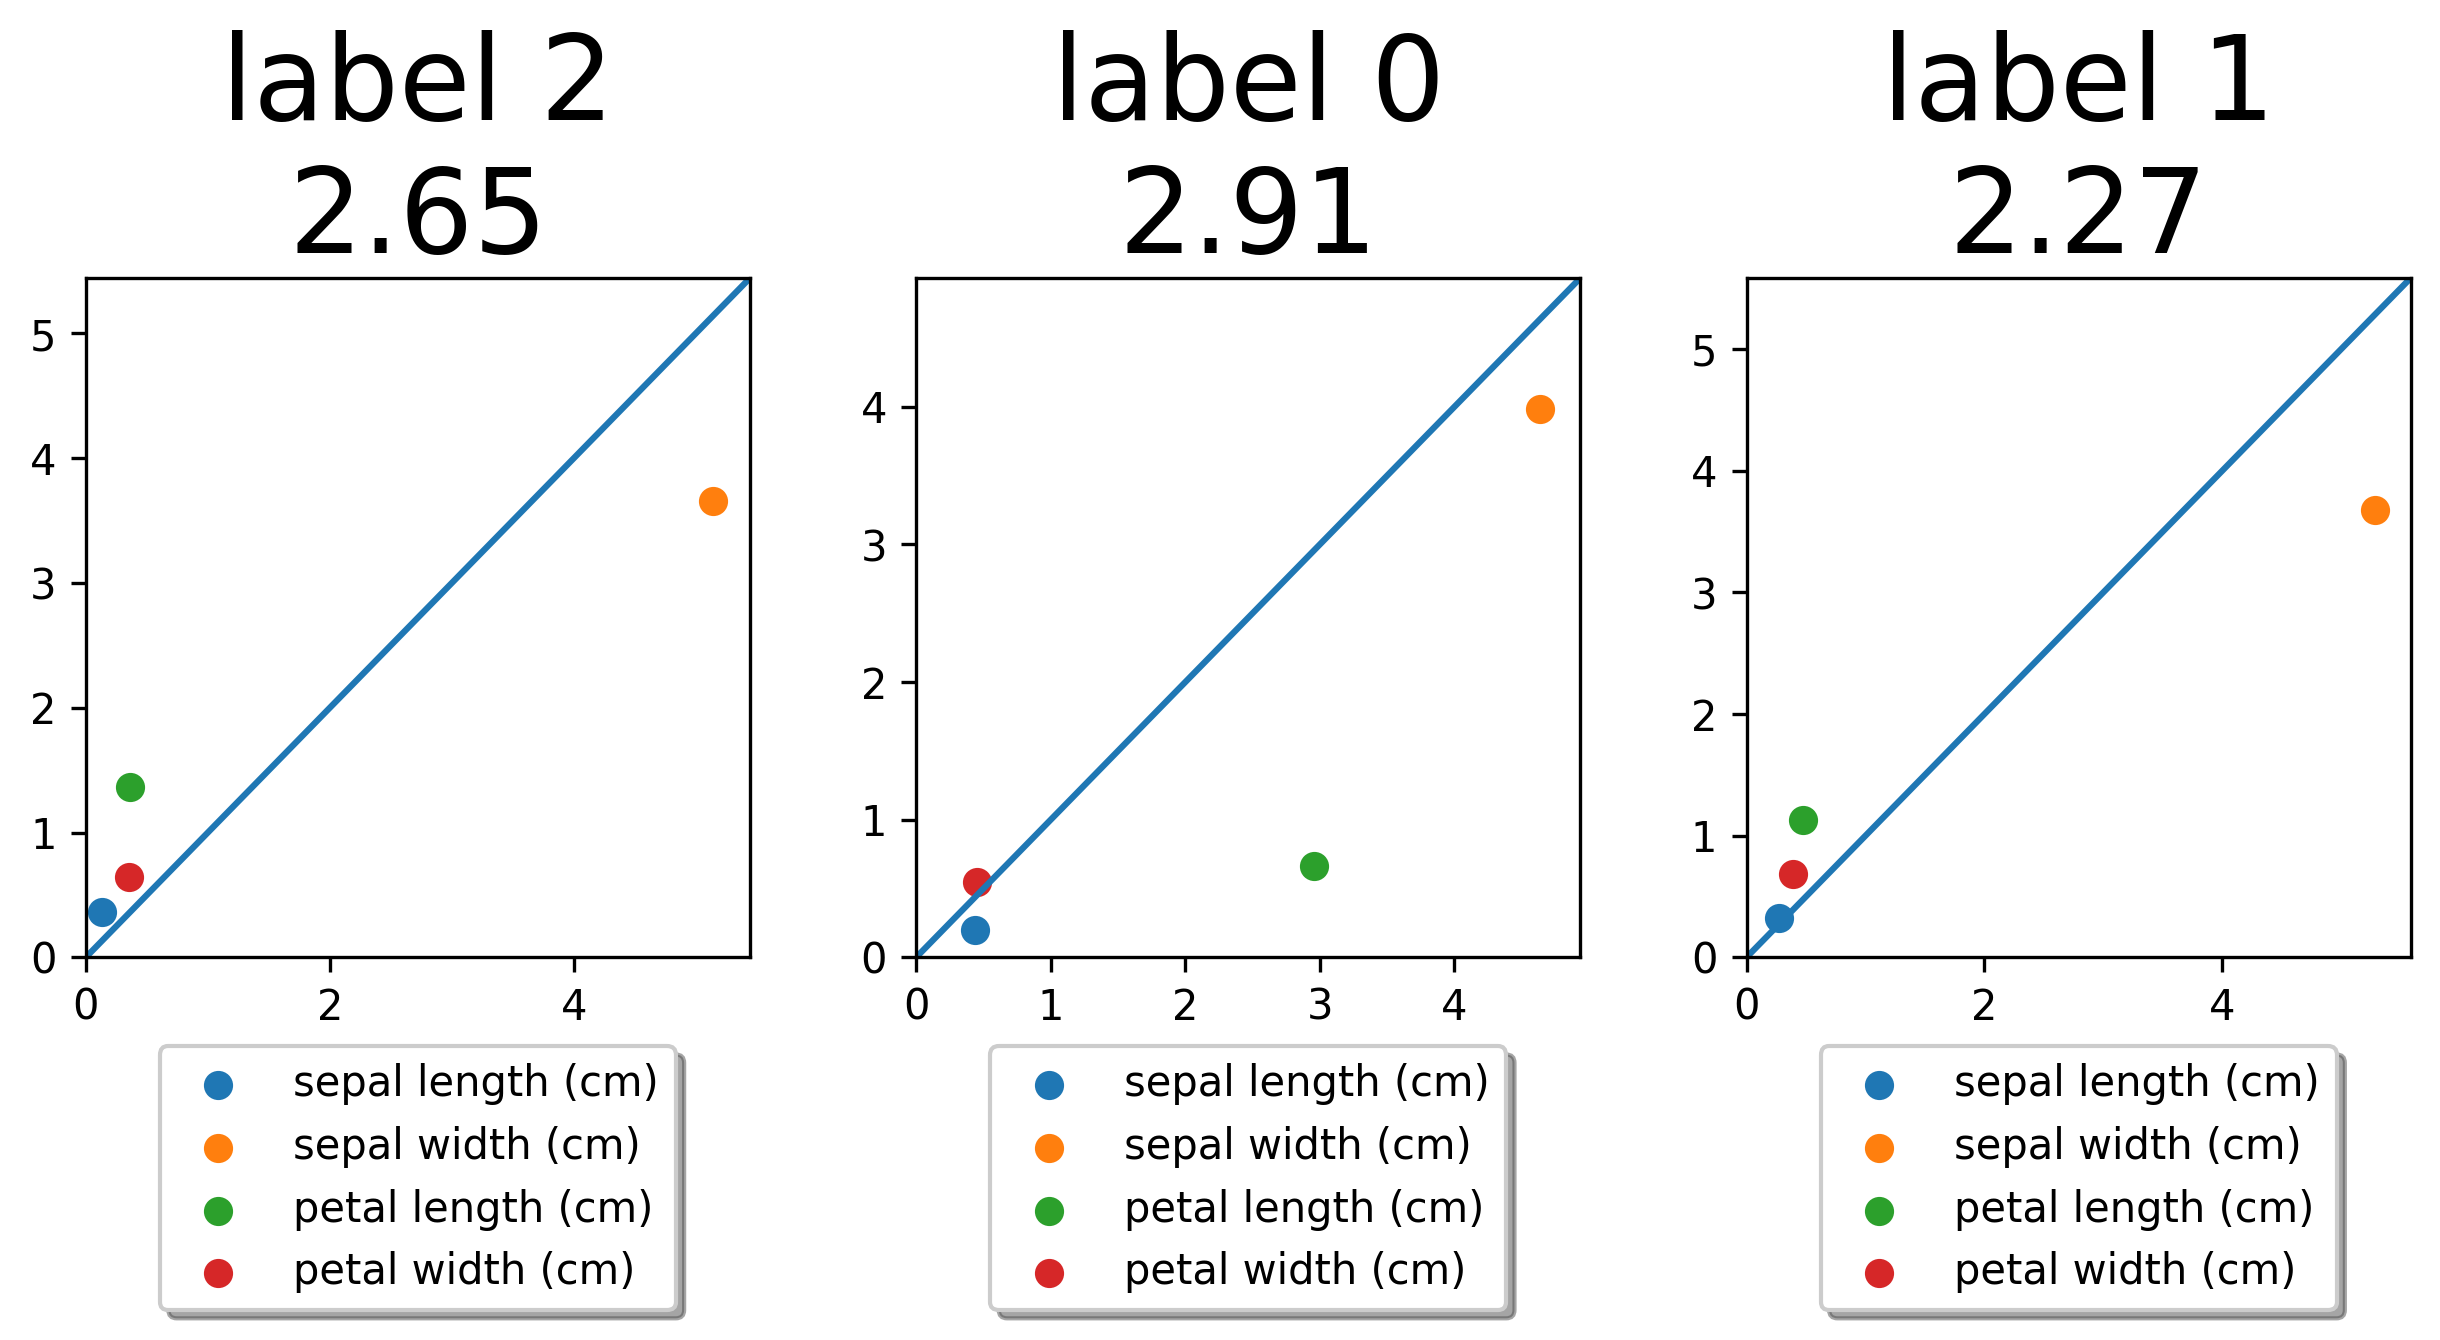

(   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
 0           0.245136          0.650077           2.299265          0.098865
 1           0.053378          1.607241           0.655142          0.289424
 2           0.224816          1.486851           1.004031          0.286368,
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
 0           0.770206          0.150758           1.270081          0.197865
 1           0.180318          0.358609           0.819629          0.538792
 2           0.902442          0.337759           1.163228          0.572011,
 [2.6492427, 2.9107664, 2.2650468])

In [62]:
Batch1, Batch2, y_1, y_2 = train_test_split(X, y, test_size=0.50, random_state=5)

noise_factor = 1
noise = []
for i in range(4):
    tmp = np.random.normal(noise_factor, 0.1*noise_factor, len(Batch1))
    noise.append(tmp)
noise = np.array(noise).T

Batch2 += noise

Combined = np.vstack((Batch1, Batch2))

reducer = umap.UMAP()
embedding = reducer.fit_transform(Combined)
scaler = MinMaxScaler()
embedding = 10*scaler.fit_transform(embedding)

fig, ax = plt.subplots(dpi=300)
scatter = ax.scatter(embedding[:,0],embedding[:,1],c=np.hstack((y_1,y_2))+1,cmap='tab10')
legend1 = ax.legend(*scatter.legend_elements(),title="Flower Types")

fig, ax = plt.subplots(dpi=300)
scatter = ax.scatter(embedding[:,0],embedding[:,1],c=np.array([0 for i in range(len(y_1))]+[1 for i in range(len(y_2))])+1)
legend1 = ax.legend(*scatter.legend_elements(),title="Datasets")

emb1 = embedding[:75,:]
emb2 = embedding[75:,:]

umap_shap(Batch1, Batch2, y_1, y_2, emb1, emb2)

### SCENARIO 2 - Tech & Systematic Batch Effect

NOISE LEVEL 0


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


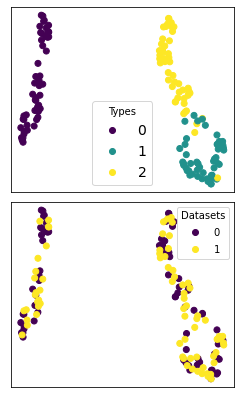

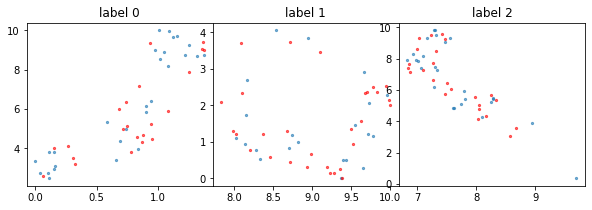

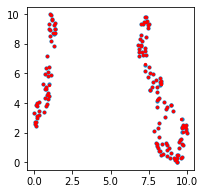

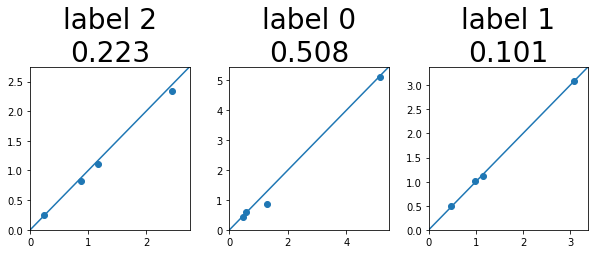

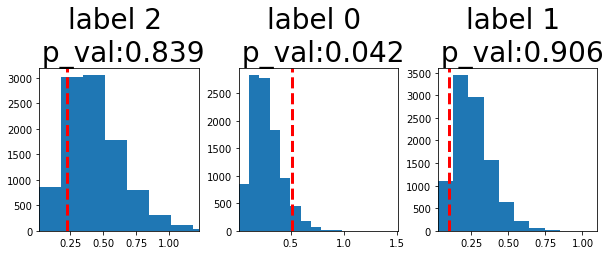

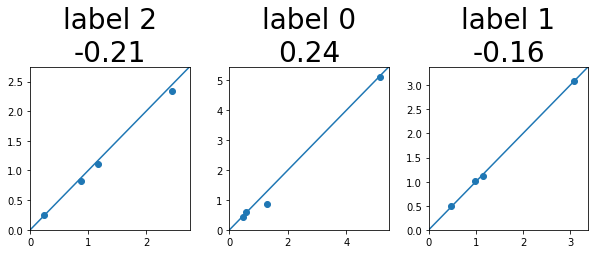

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0           0.402712          0.025577           0.048321          0.031444
1           0.023935          0.026005           0.006665          0.043937
2           0.057735          0.007129           0.110203          0.048104
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0           0.376959          0.044635           0.009417          0.069261
1           0.024075          0.054792           0.002162          0.038828
2           0.067801          0.029785           0.046028          0.042277
------------------------------------------------------------------------
NOISE LEVEL 1


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


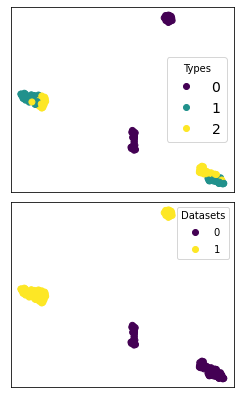

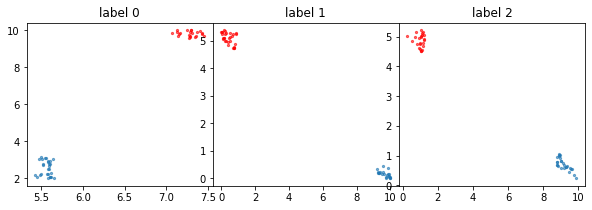

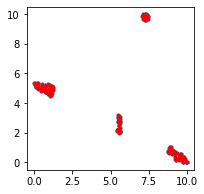

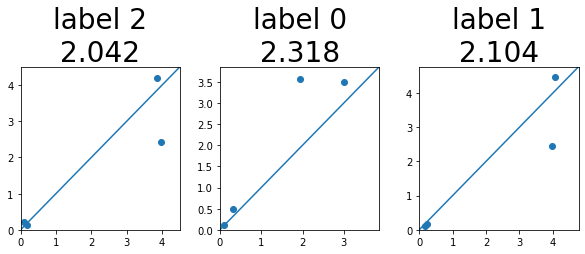

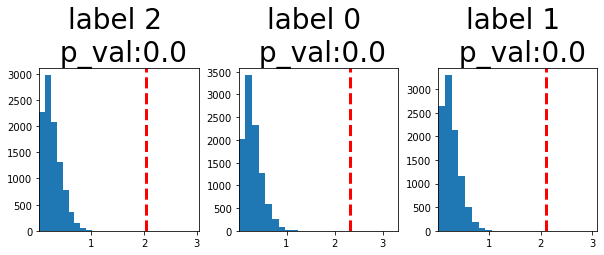

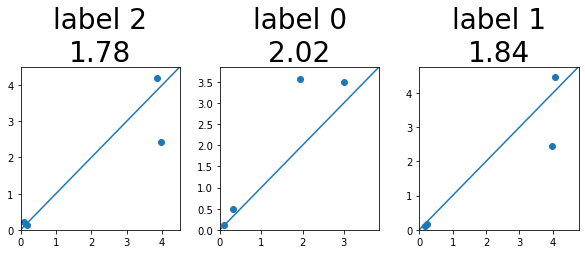

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0           0.196640          0.485074           1.611110          0.025284
1           0.082115          1.537037           0.405391          0.079469
2           0.043036          1.540490           0.341270          0.117362
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0           0.485142          0.148870           0.585283          0.230662
1           0.400381          0.478689           0.094980          0.558685
2           0.266762          0.480590           0.084535          0.739590
------------------------------------------------------------------------


In [12]:
noise_levels = [0,1]#[0 + 0.1*i for i in range(10)]
SC = []
for n in noise_levels:
    print('NOISE LEVEL {}'.format(n))
    Batch1, Batch2, y_1, y_2 = train_test_split(X, y, test_size=0.50, random_state=5)
    noise_factor = n
    noise = []
    for i in range(4):
        tmp = np.random.normal(noise_factor, 0.1*noise_factor, len(Batch1))
        noise.append(tmp)
    noise = np.array(noise).T
    Batch2 += noise

    Combined = np.vstack((Batch1, Batch2))
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(Combined)
    
    scaler = MinMaxScaler()
    embedding = 10*scaler.fit_transform(embedding)
    
    fig, axs = plt.subplots(2,1, figsize=(4, 7), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .05, wspace=.001)
    axs = axs.ravel()

    scatter = axs[0].scatter(embedding[:,0],embedding[:,1],c=np.hstack((y_1,y_2)))
    legend1 = axs[0].legend(*scatter.legend_elements(),title="Types",prop={'size':14})
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    scatter = axs[1].scatter(embedding[:,0],embedding[:,1],c=[0 for i in range(len(y_1))]+[1 for i in range(len(y_2))])
    legend1 = axs[1].legend(*scatter.legend_elements(),title="Datasets")
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    
    emb1 = embedding[:75,:]
    emb2 = embedding[75:,:]
    
    g1,g2,sc=umap_shap(Batch1, Batch2, y_1, y_2, emb1, emb2)
    SC.append(sc)
    print(g1)
    print(g2)
    print('------------------------------------------------------------------------')

Text(0, 0.5, 'Variation Score')

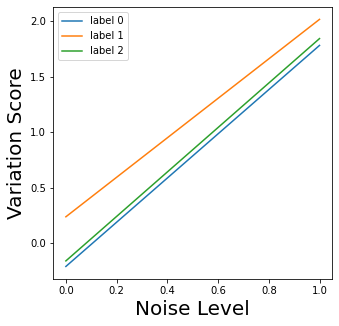

In [13]:
tmp = np.array(SC)
plt.figure(figsize=(5,5))
plt.plot(noise_levels,tmp[:,0])
plt.plot(noise_levels,tmp[:,1])
plt.plot(noise_levels,tmp[:,2])
plt.legend(['label 0','label 1','label 2'])
plt.xlabel('Noise Level',fontsize=20)
plt.ylabel('Variation Score',fontsize=20)

### Scenario 3 - Systematic Batch Effect on certain Features  

Perturbed Feature : petal width (cm)


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


(4,)
(4,)
(4,)


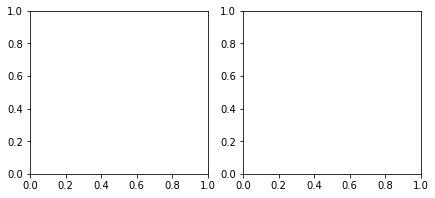

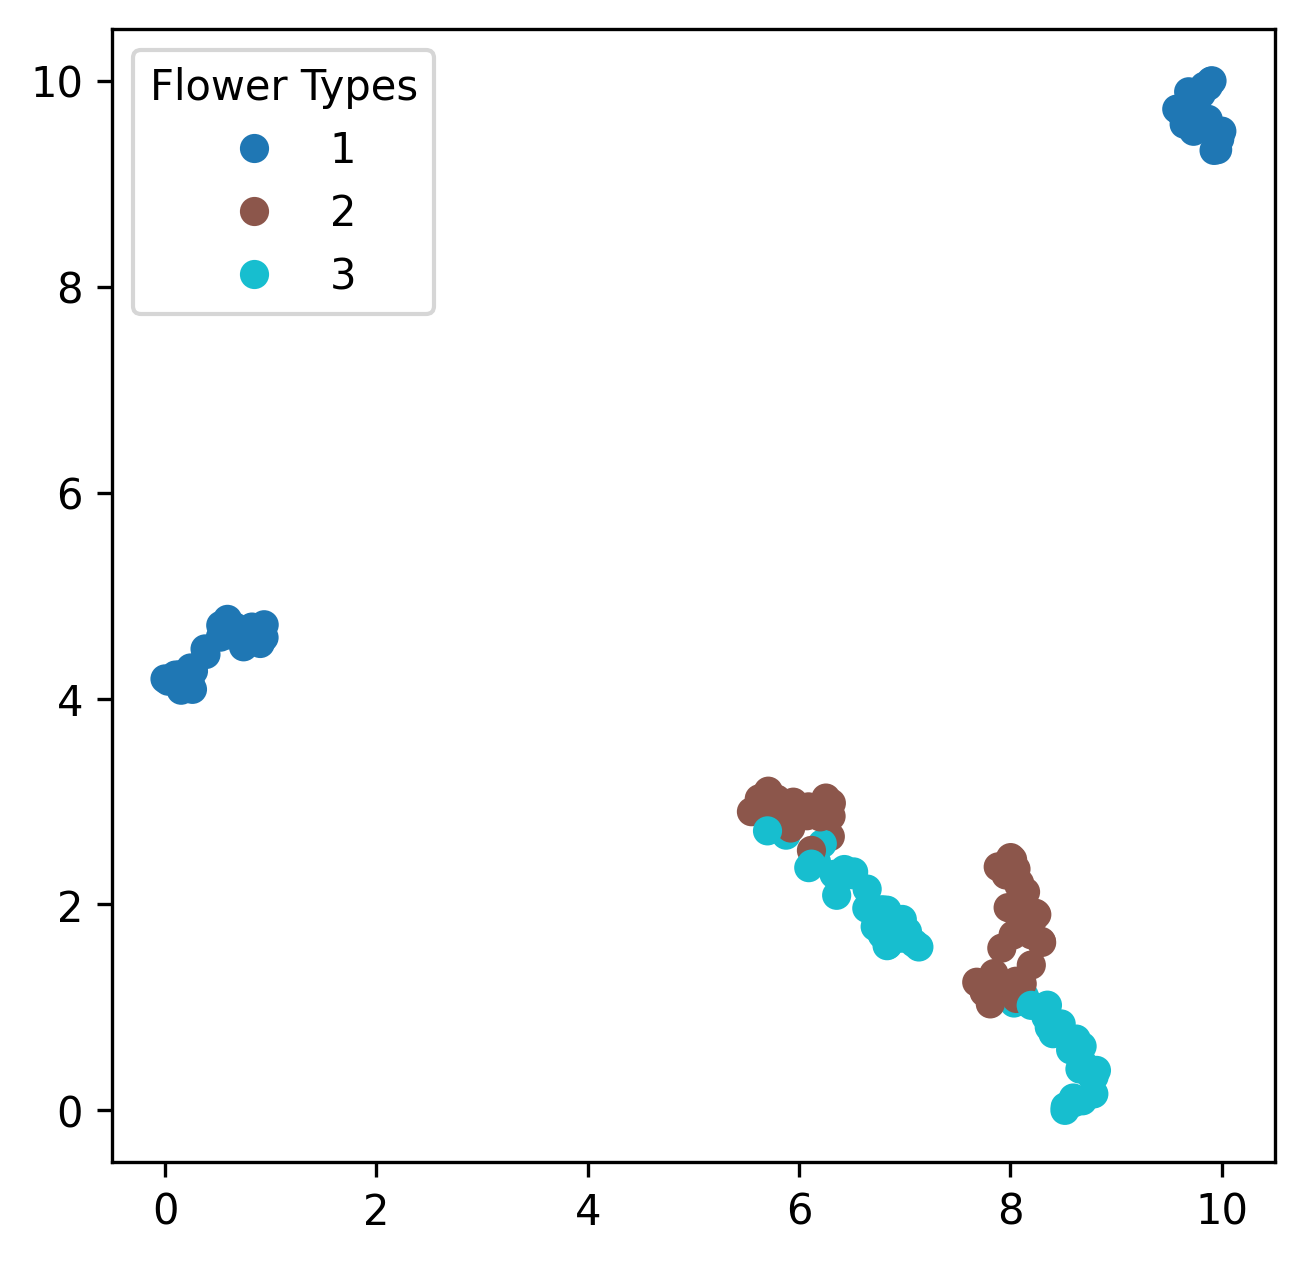

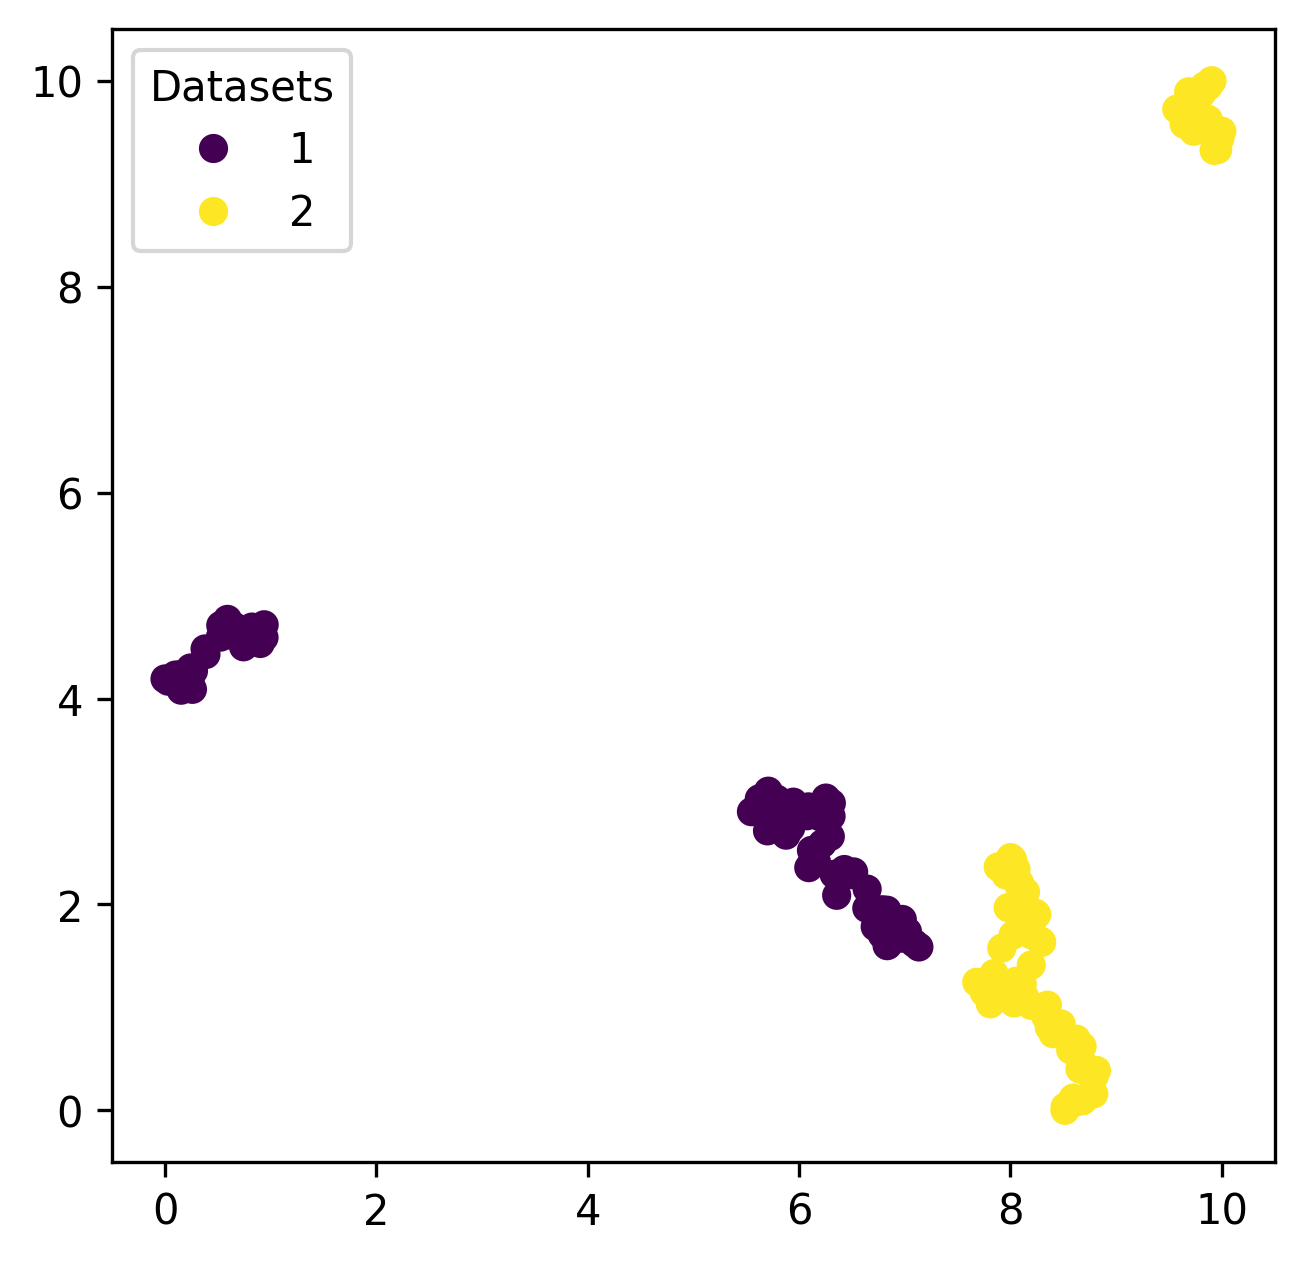

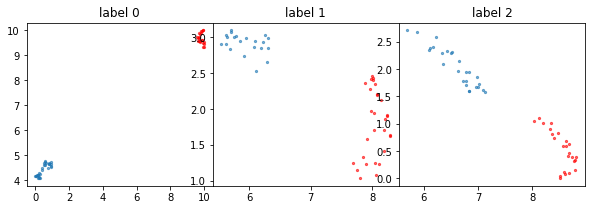

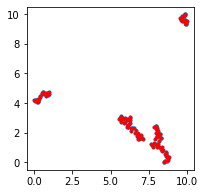

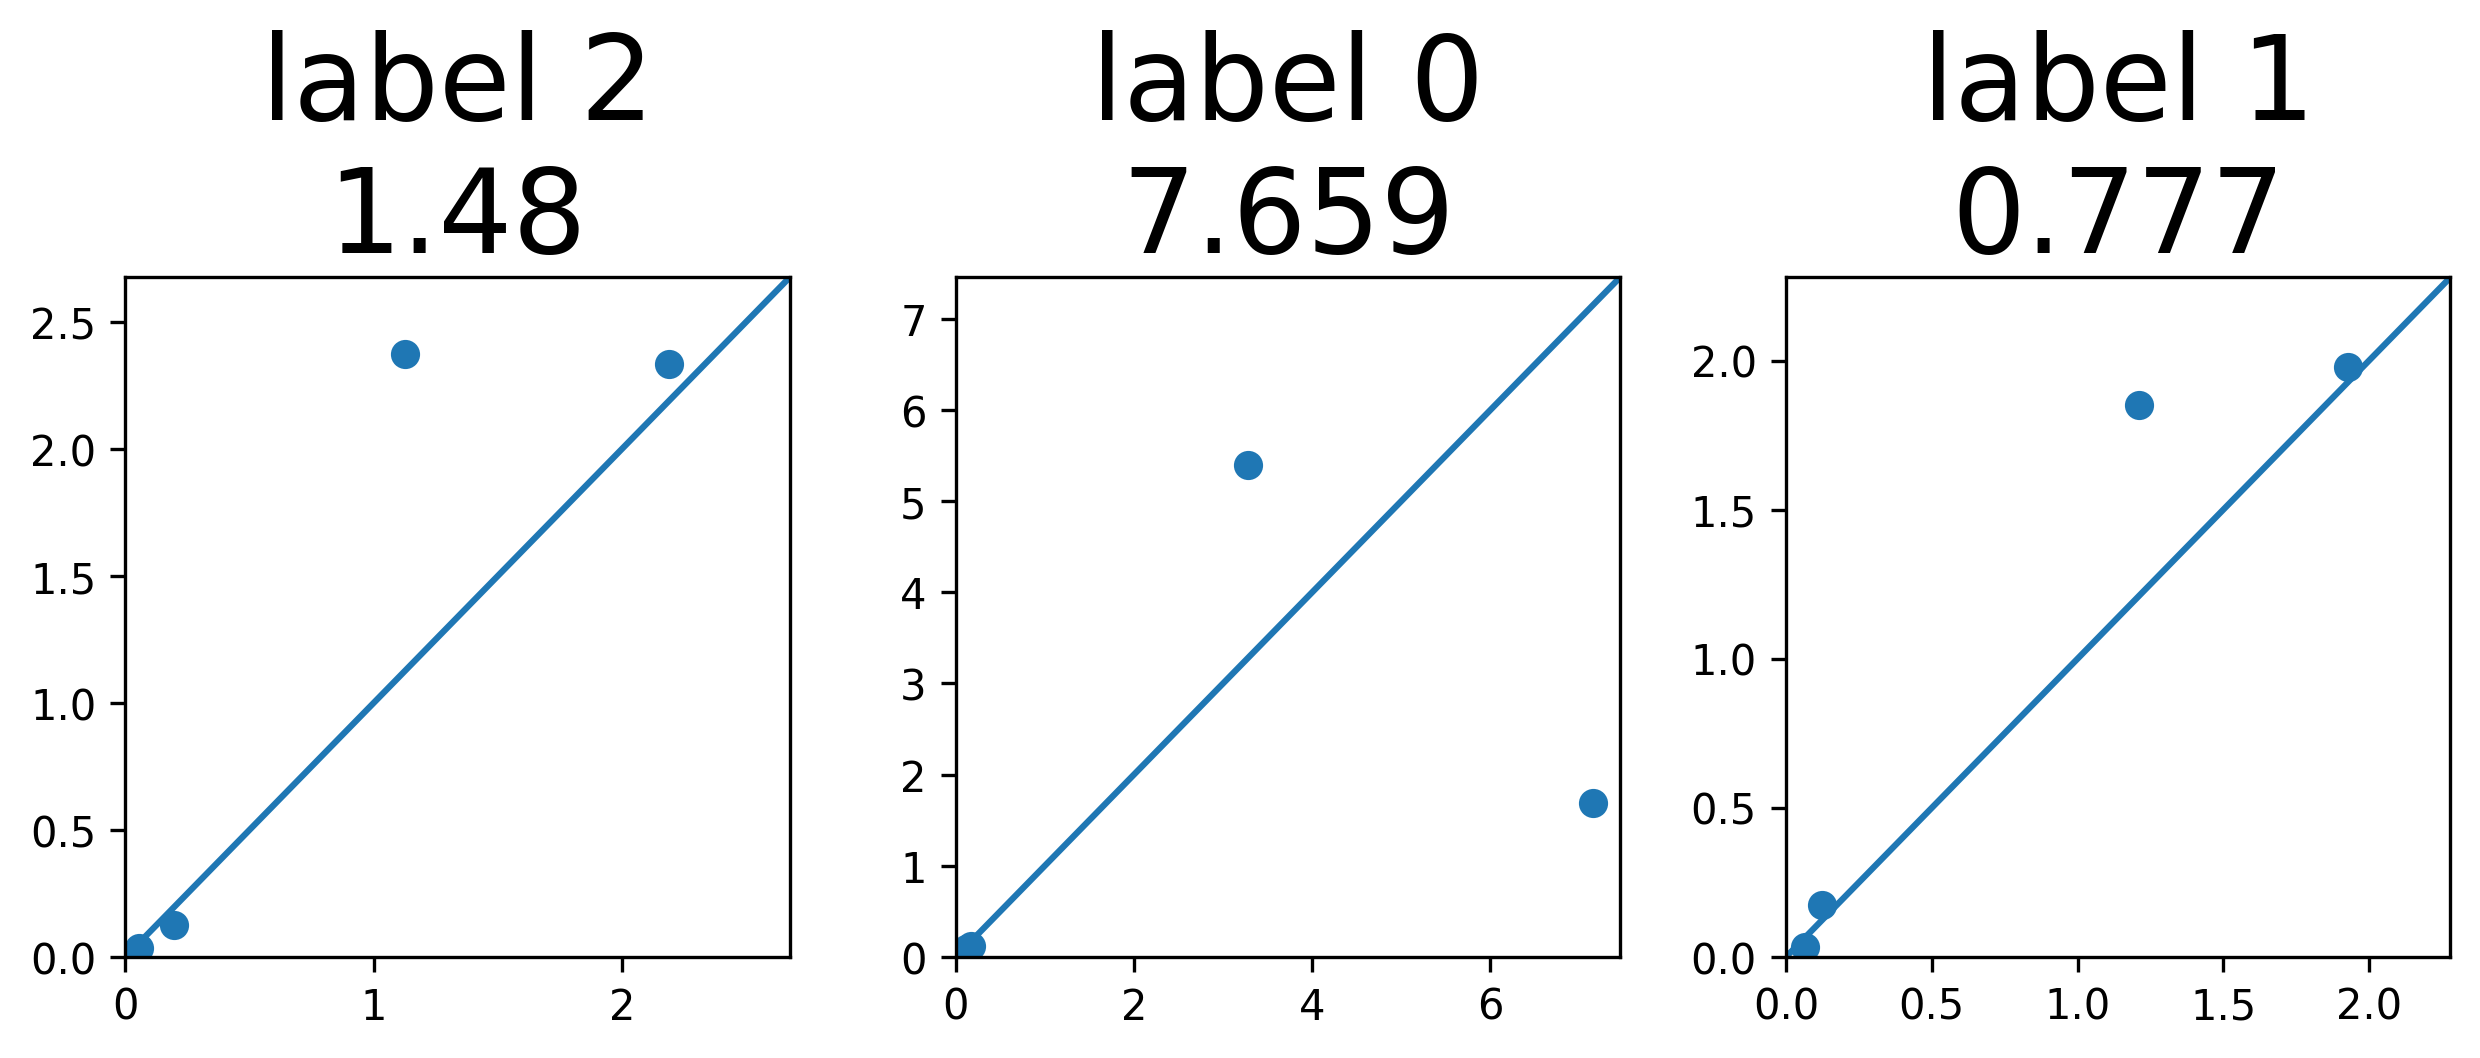

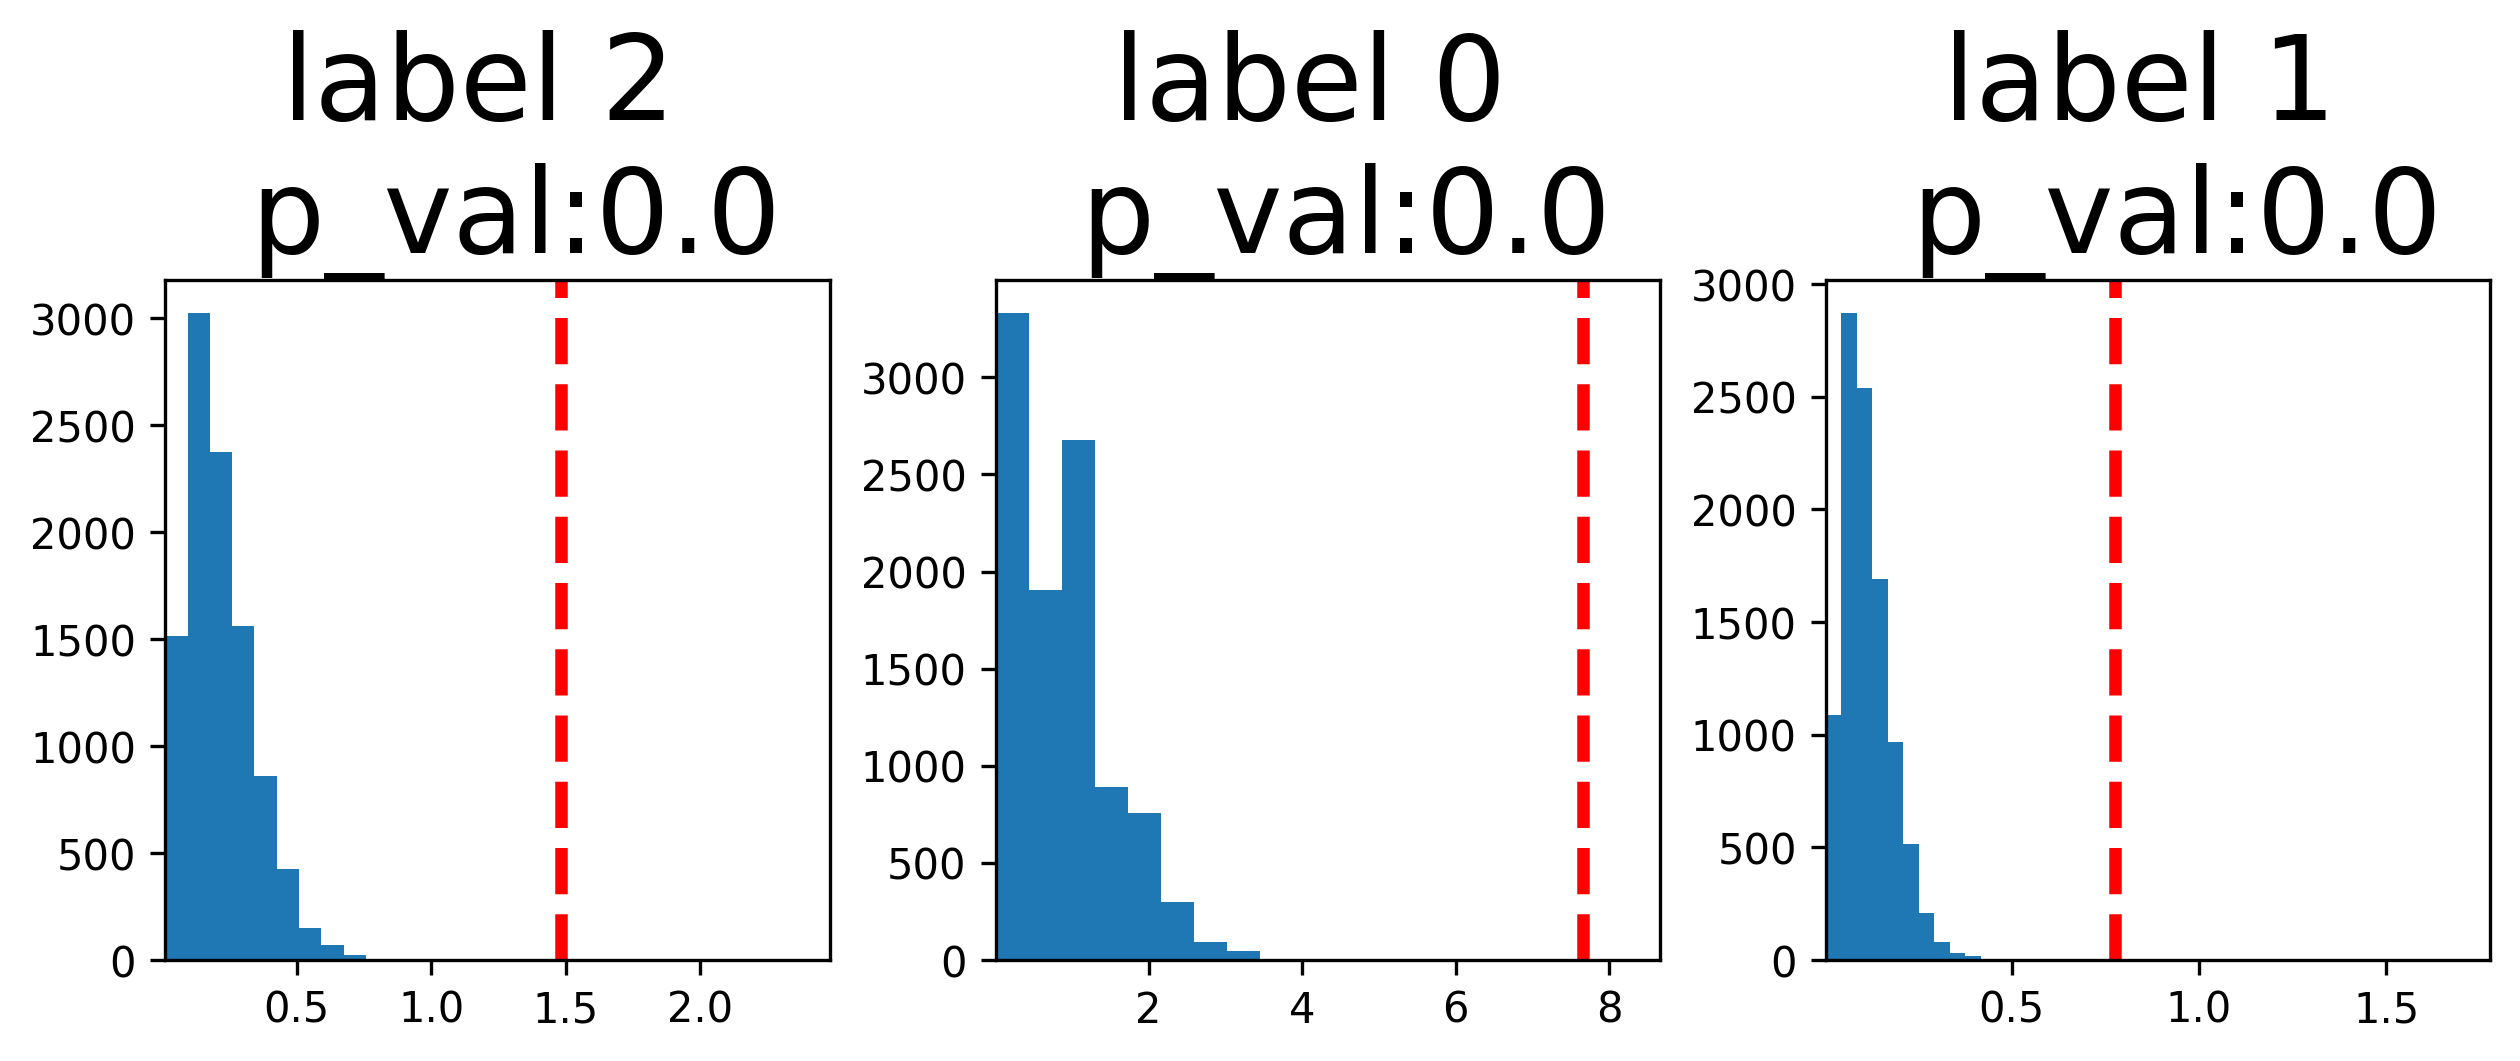

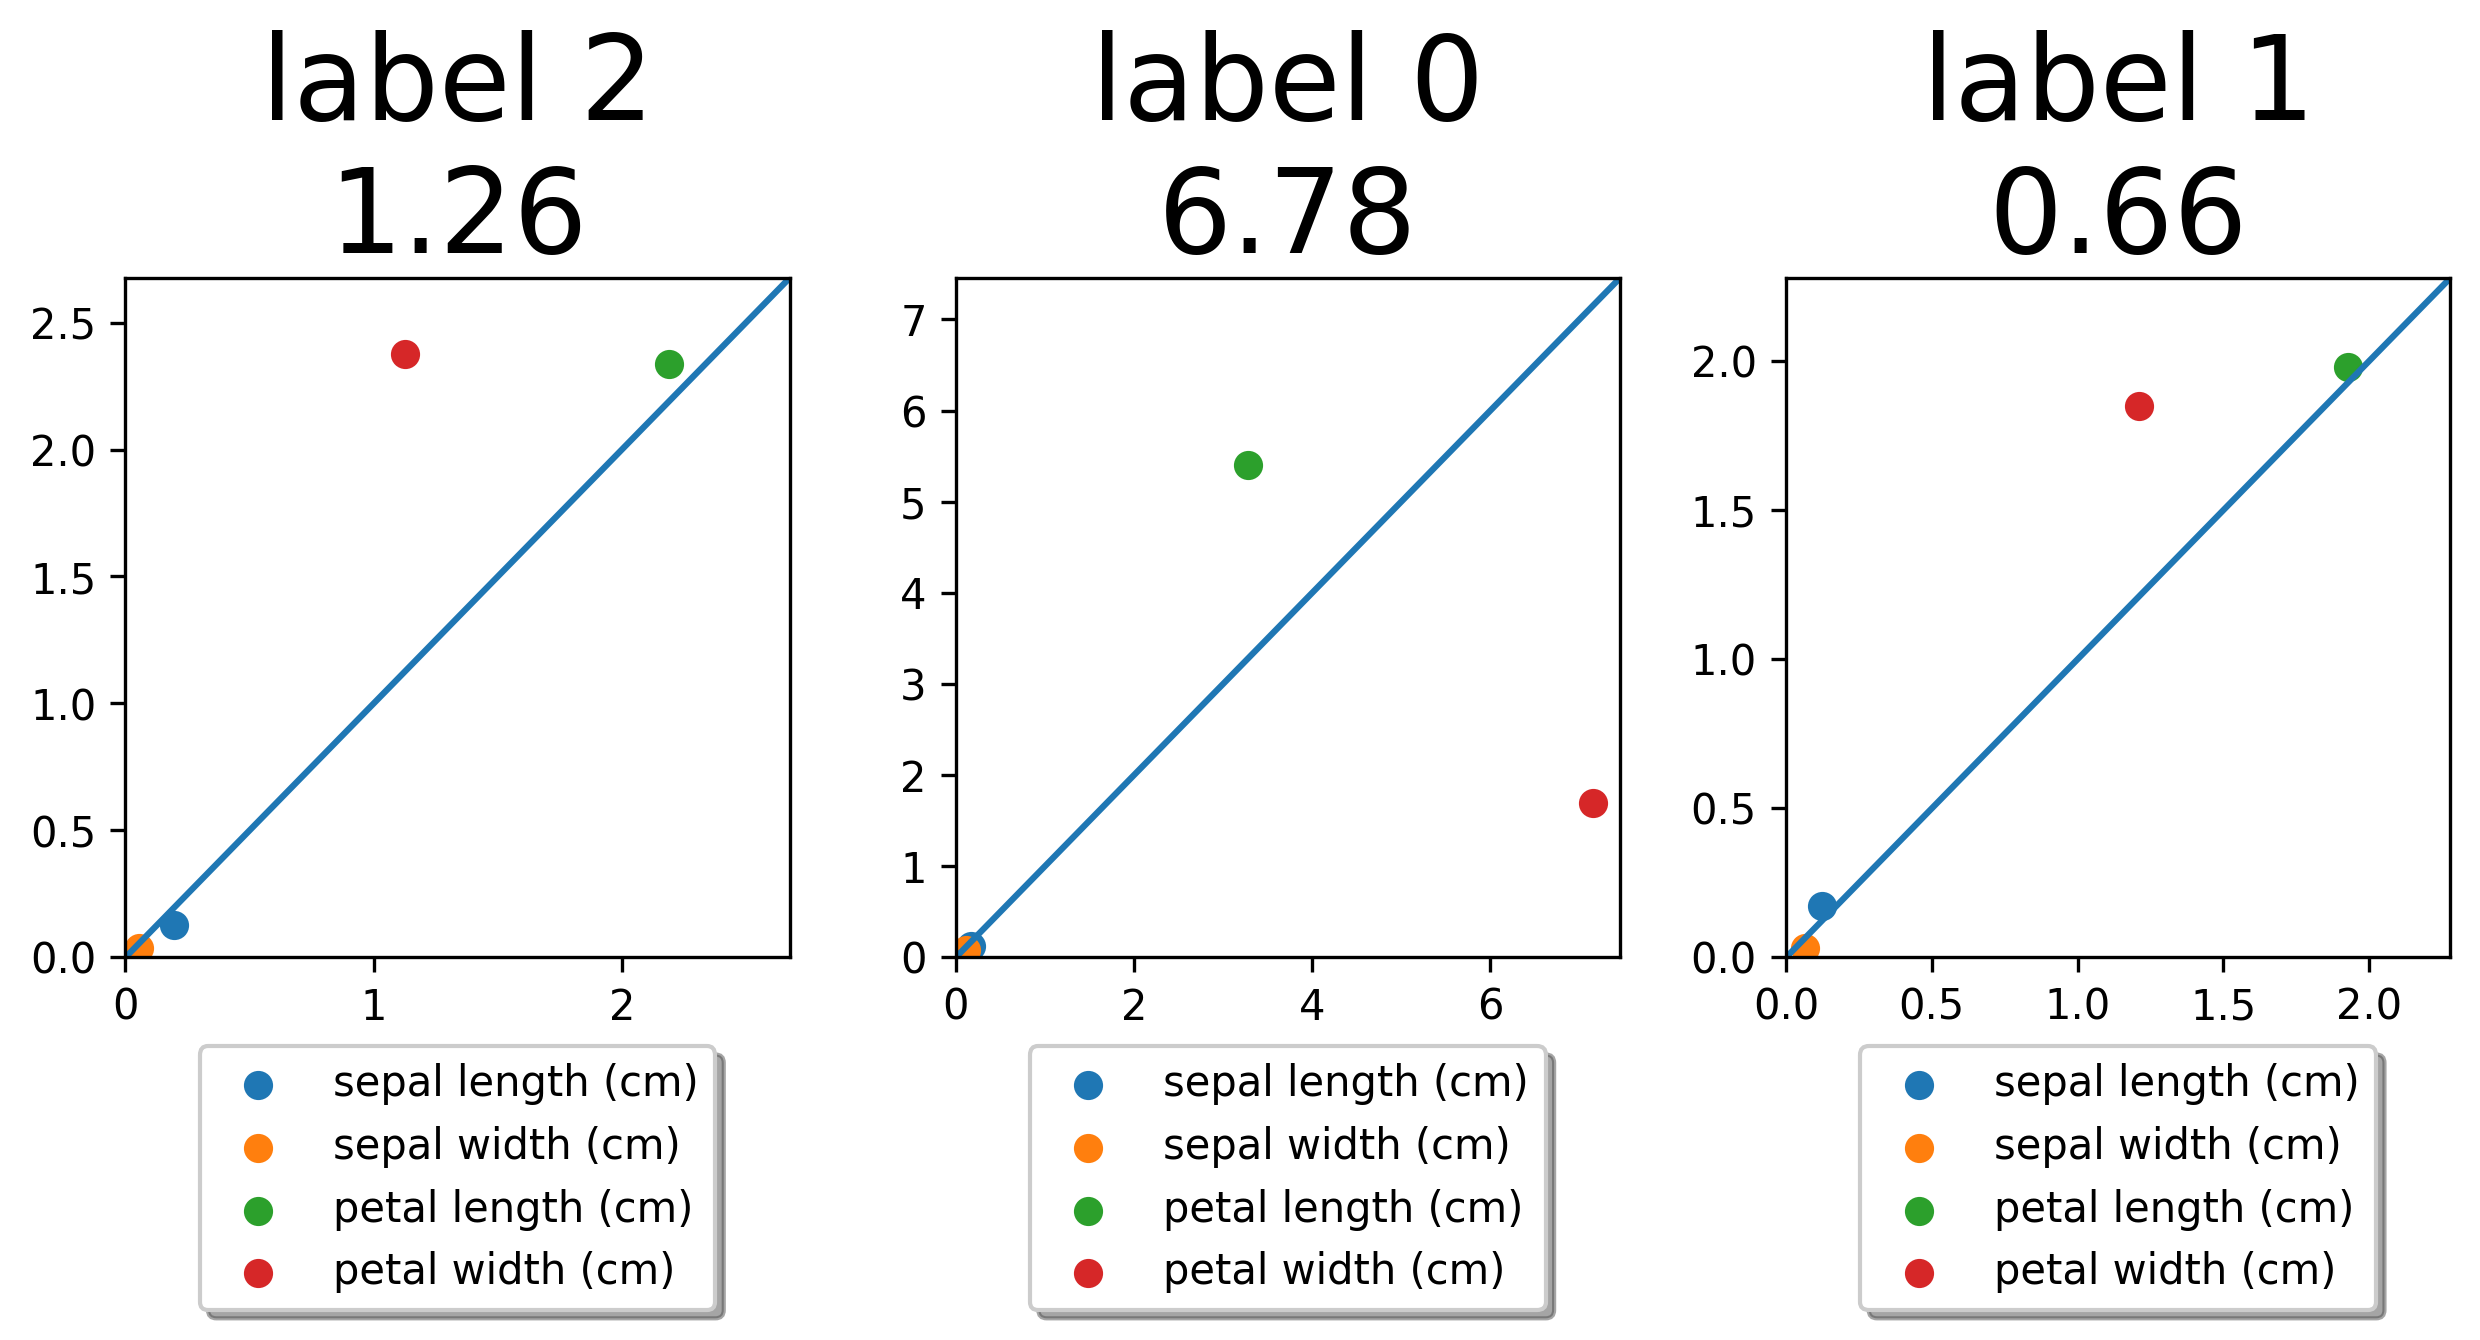

------------------------------------------------------------------------


In [70]:
G = []
G2 = []
features_idx = [3]
for n in features_idx:
    Batch1, Batch2, y_1, y_2 = train_test_split(X, y, test_size=0.50, random_state=5)
    noise_factor = 0.5
    print('Perturbed Feature : {}'.format(np.array(feature_names)[n]))
    noise = []
    
    tmp = np.random.normal(noise_factor, 0.1*noise_factor, len(Batch1))
    noise.append(tmp)
    noise = np.array(noise).T
    noise = np.reshape(noise,(len(noise),))
    Batch2[:,n] += noise
   
    Combined = np.vstack((Batch1, Batch2))
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(Combined)
    
    scaler = MinMaxScaler()
    embedding = 10*scaler.fit_transform(embedding)
    
    fig, axs = plt.subplots(1,2, figsize=(7, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.2)
    axs = axs.ravel()

    fig, ax = plt.subplots(dpi=300,figsize=(5,5))
    scatter = ax.scatter(embedding[:,0],embedding[:,1],c=np.hstack((y_1,y_2))+1,cmap='tab10')
    legend1 = ax.legend(*scatter.legend_elements(),title="Flower Types")

    fig, ax = plt.subplots(dpi=300,figsize=(5,5))
    scatter = ax.scatter(embedding[:,0],embedding[:,1],c=np.array([0 for i in range(len(y_1))]+[1 for i in range(len(y_2))])+1)
    legend1 = ax.legend(*scatter.legend_elements(),title="Datasets")
    emb1 = embedding[:75,:]
    emb2 = embedding[75:,:]
    
    g,g2,s = umap_shap(Batch1, Batch2, y_1, y_2, emb1, emb2)
    G.append(g)
    G2.append(g2)
    print('------------------------------------------------------------------------')

In [71]:
G[0]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.045902,0.024941,2.121923,5.466040
1,0.050840,0.033503,0.051886,0.640701
2,0.067616,0.019253,0.144742,1.248430


### Scenario 4 - Batch Effect on one cell type only  

Type : 0


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


(4,)
(4,)
(4,)


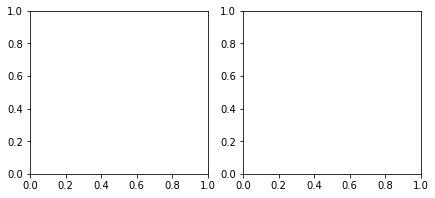

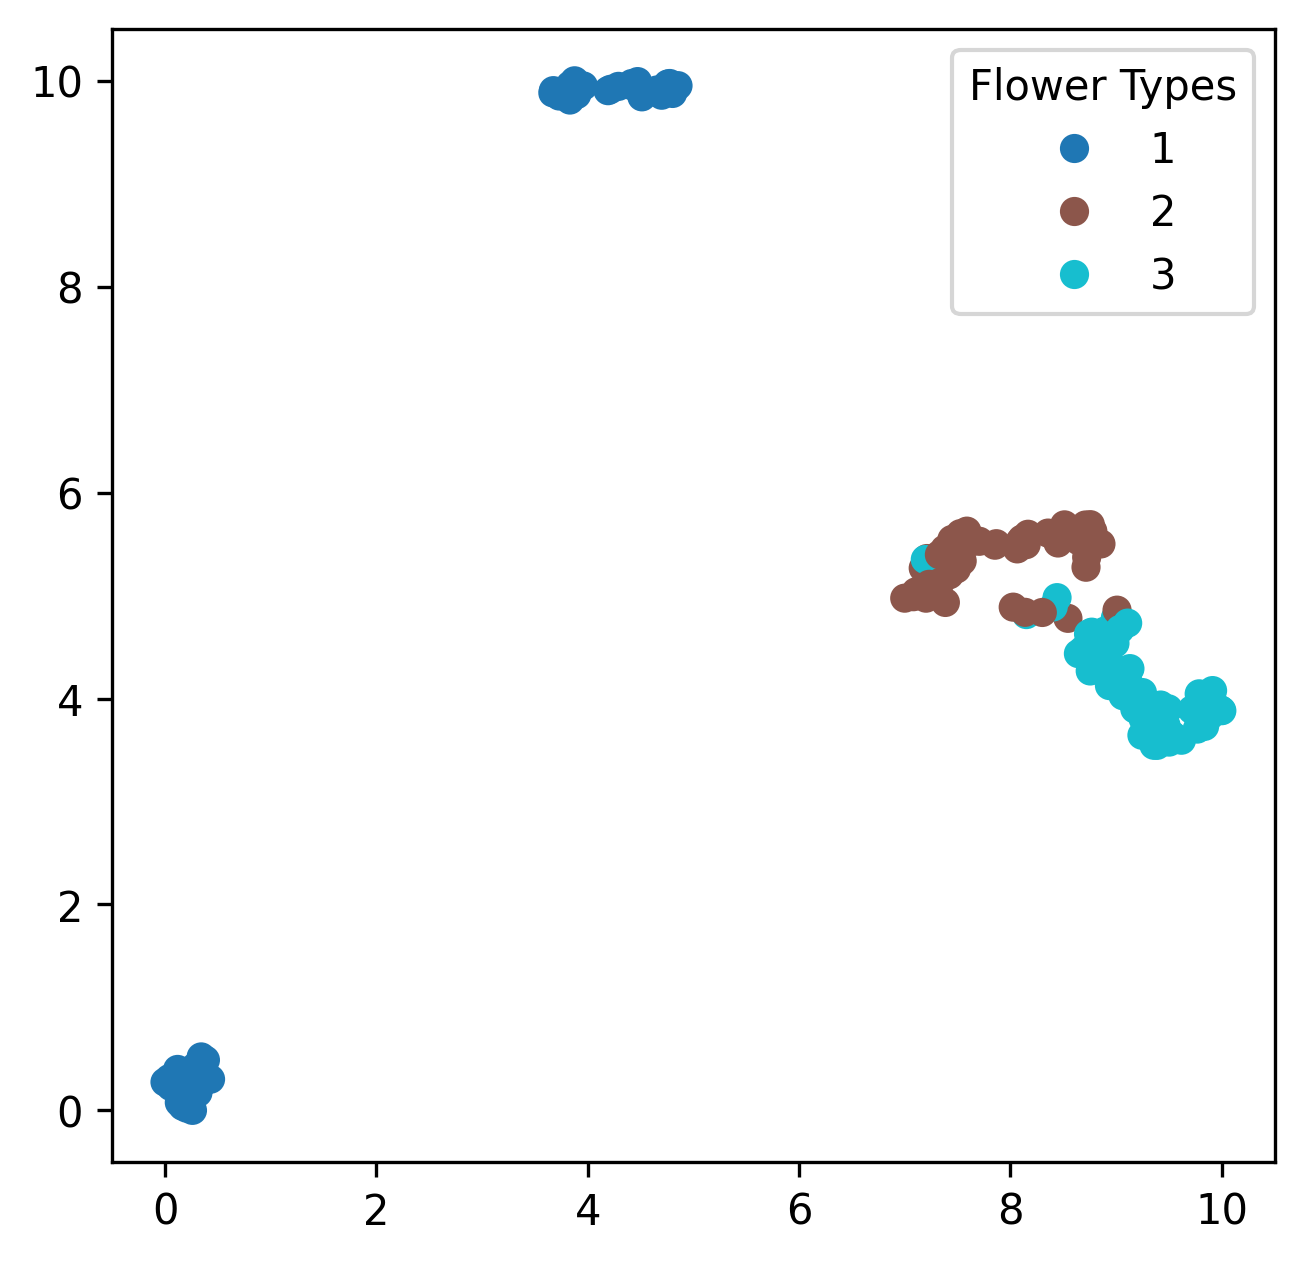

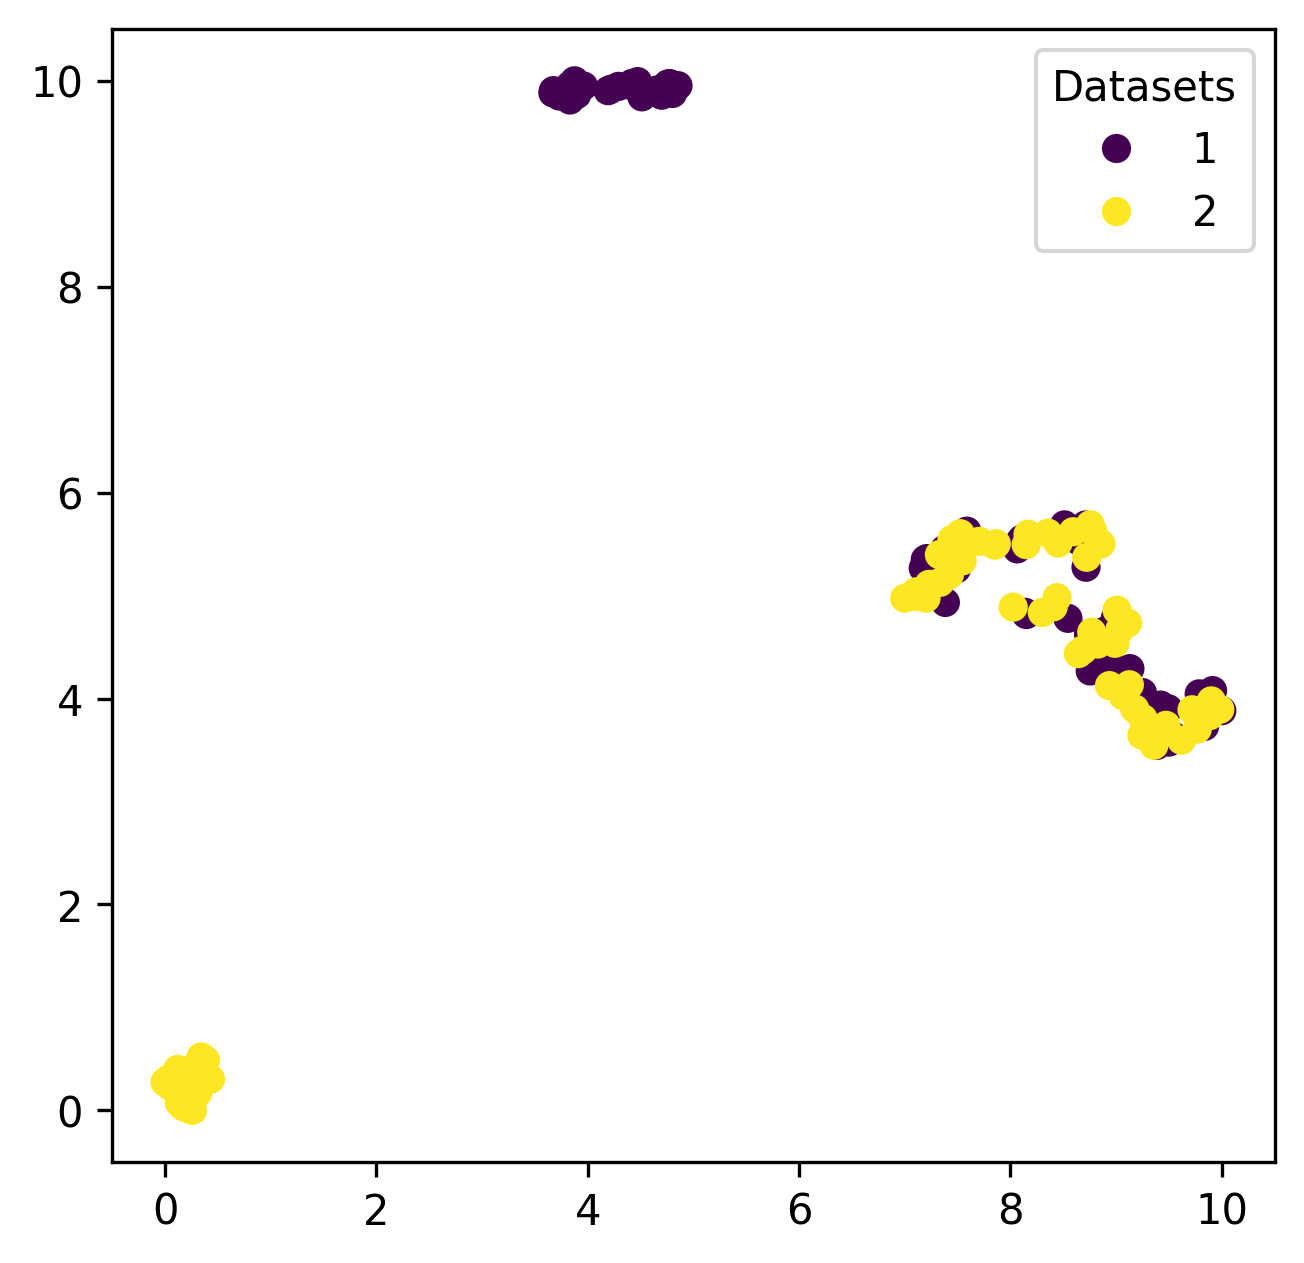

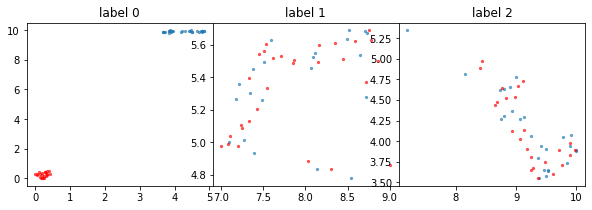

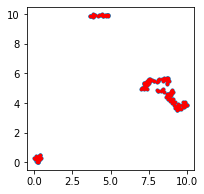

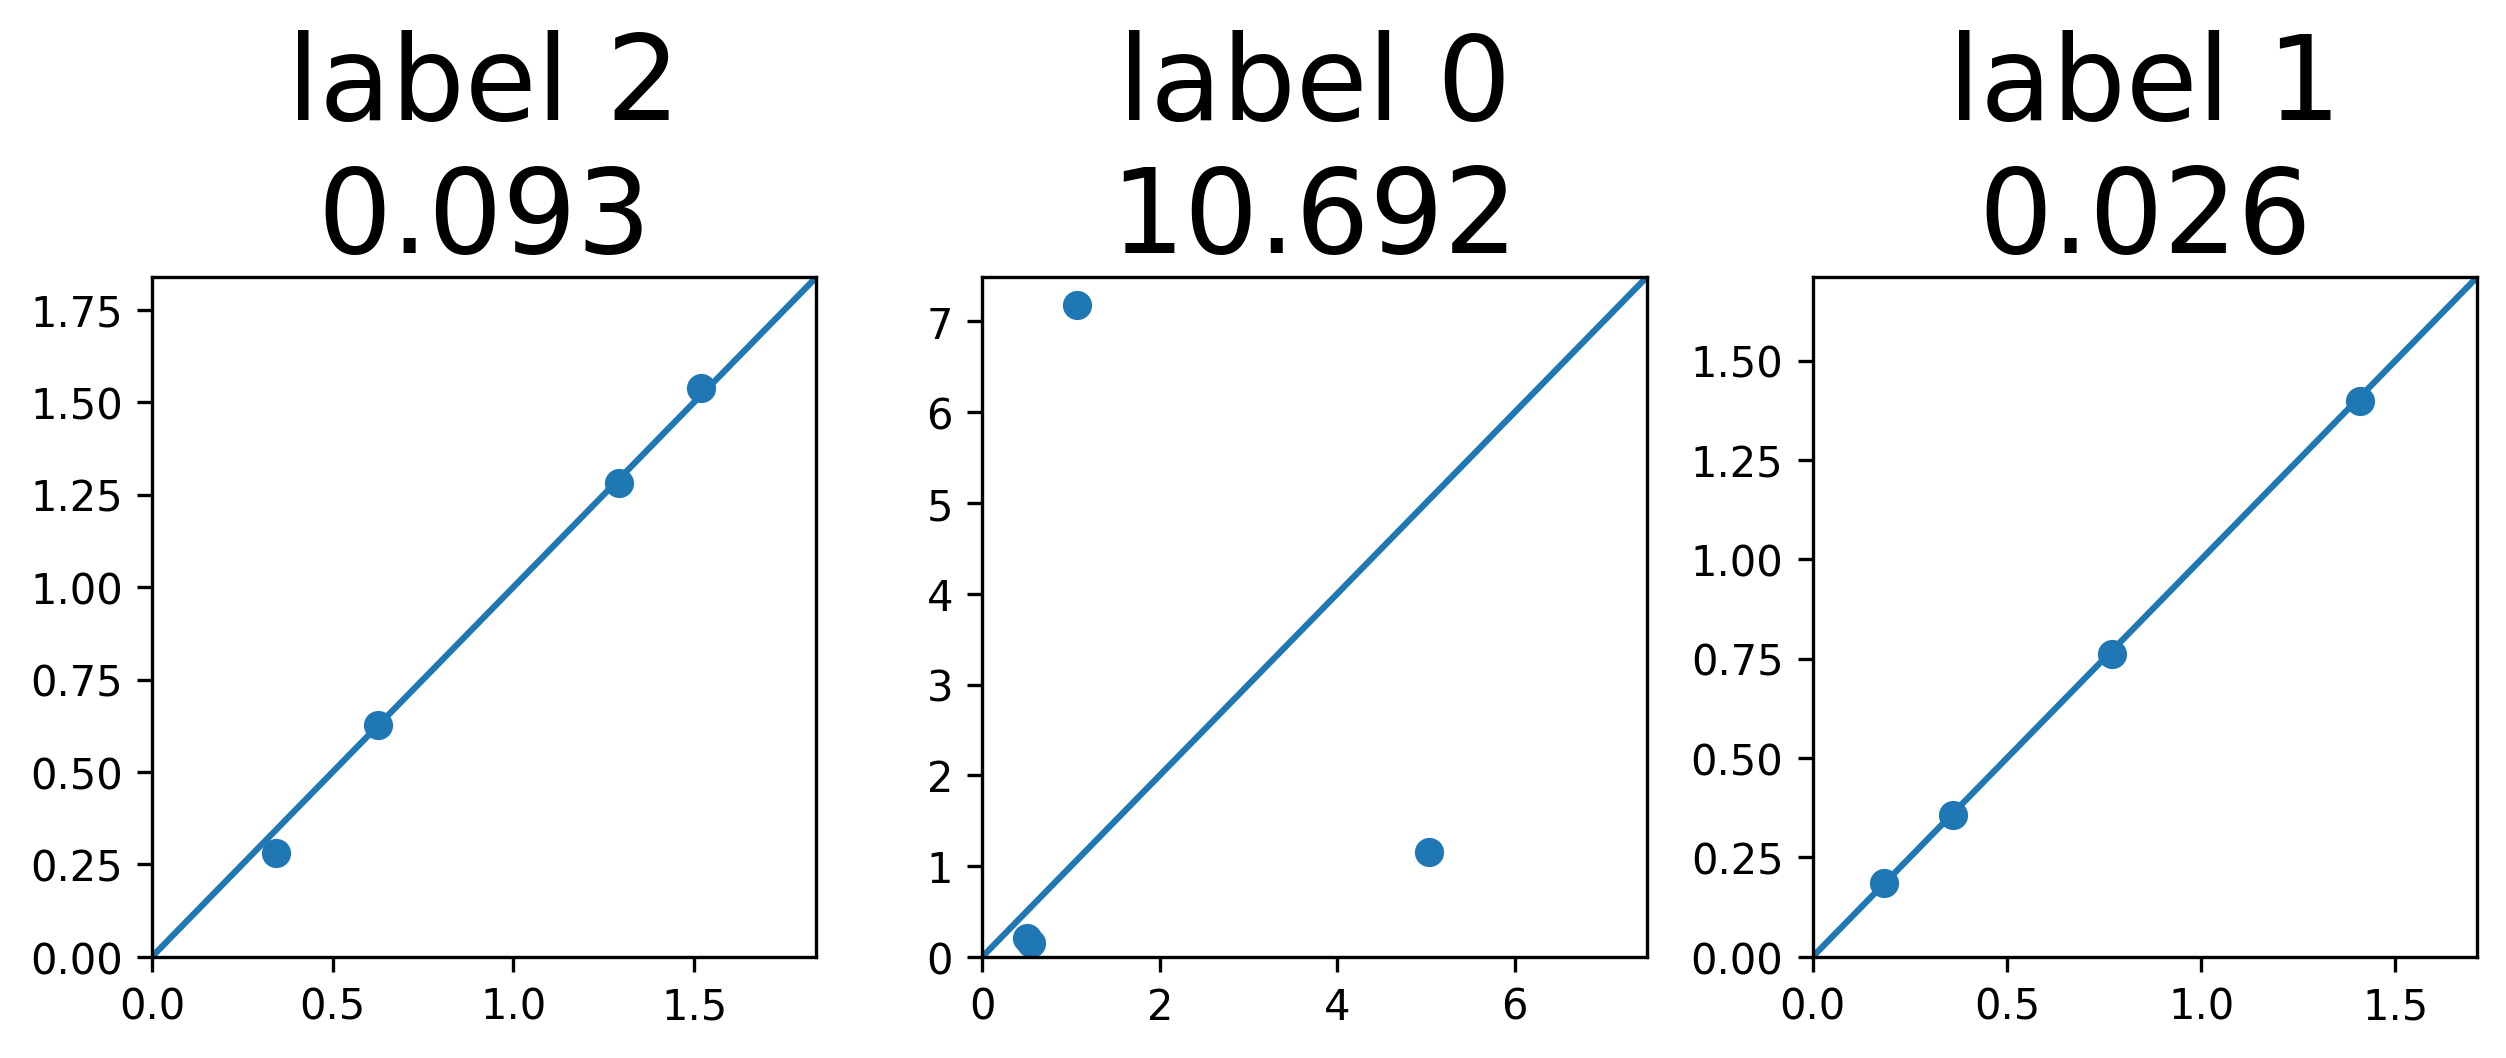

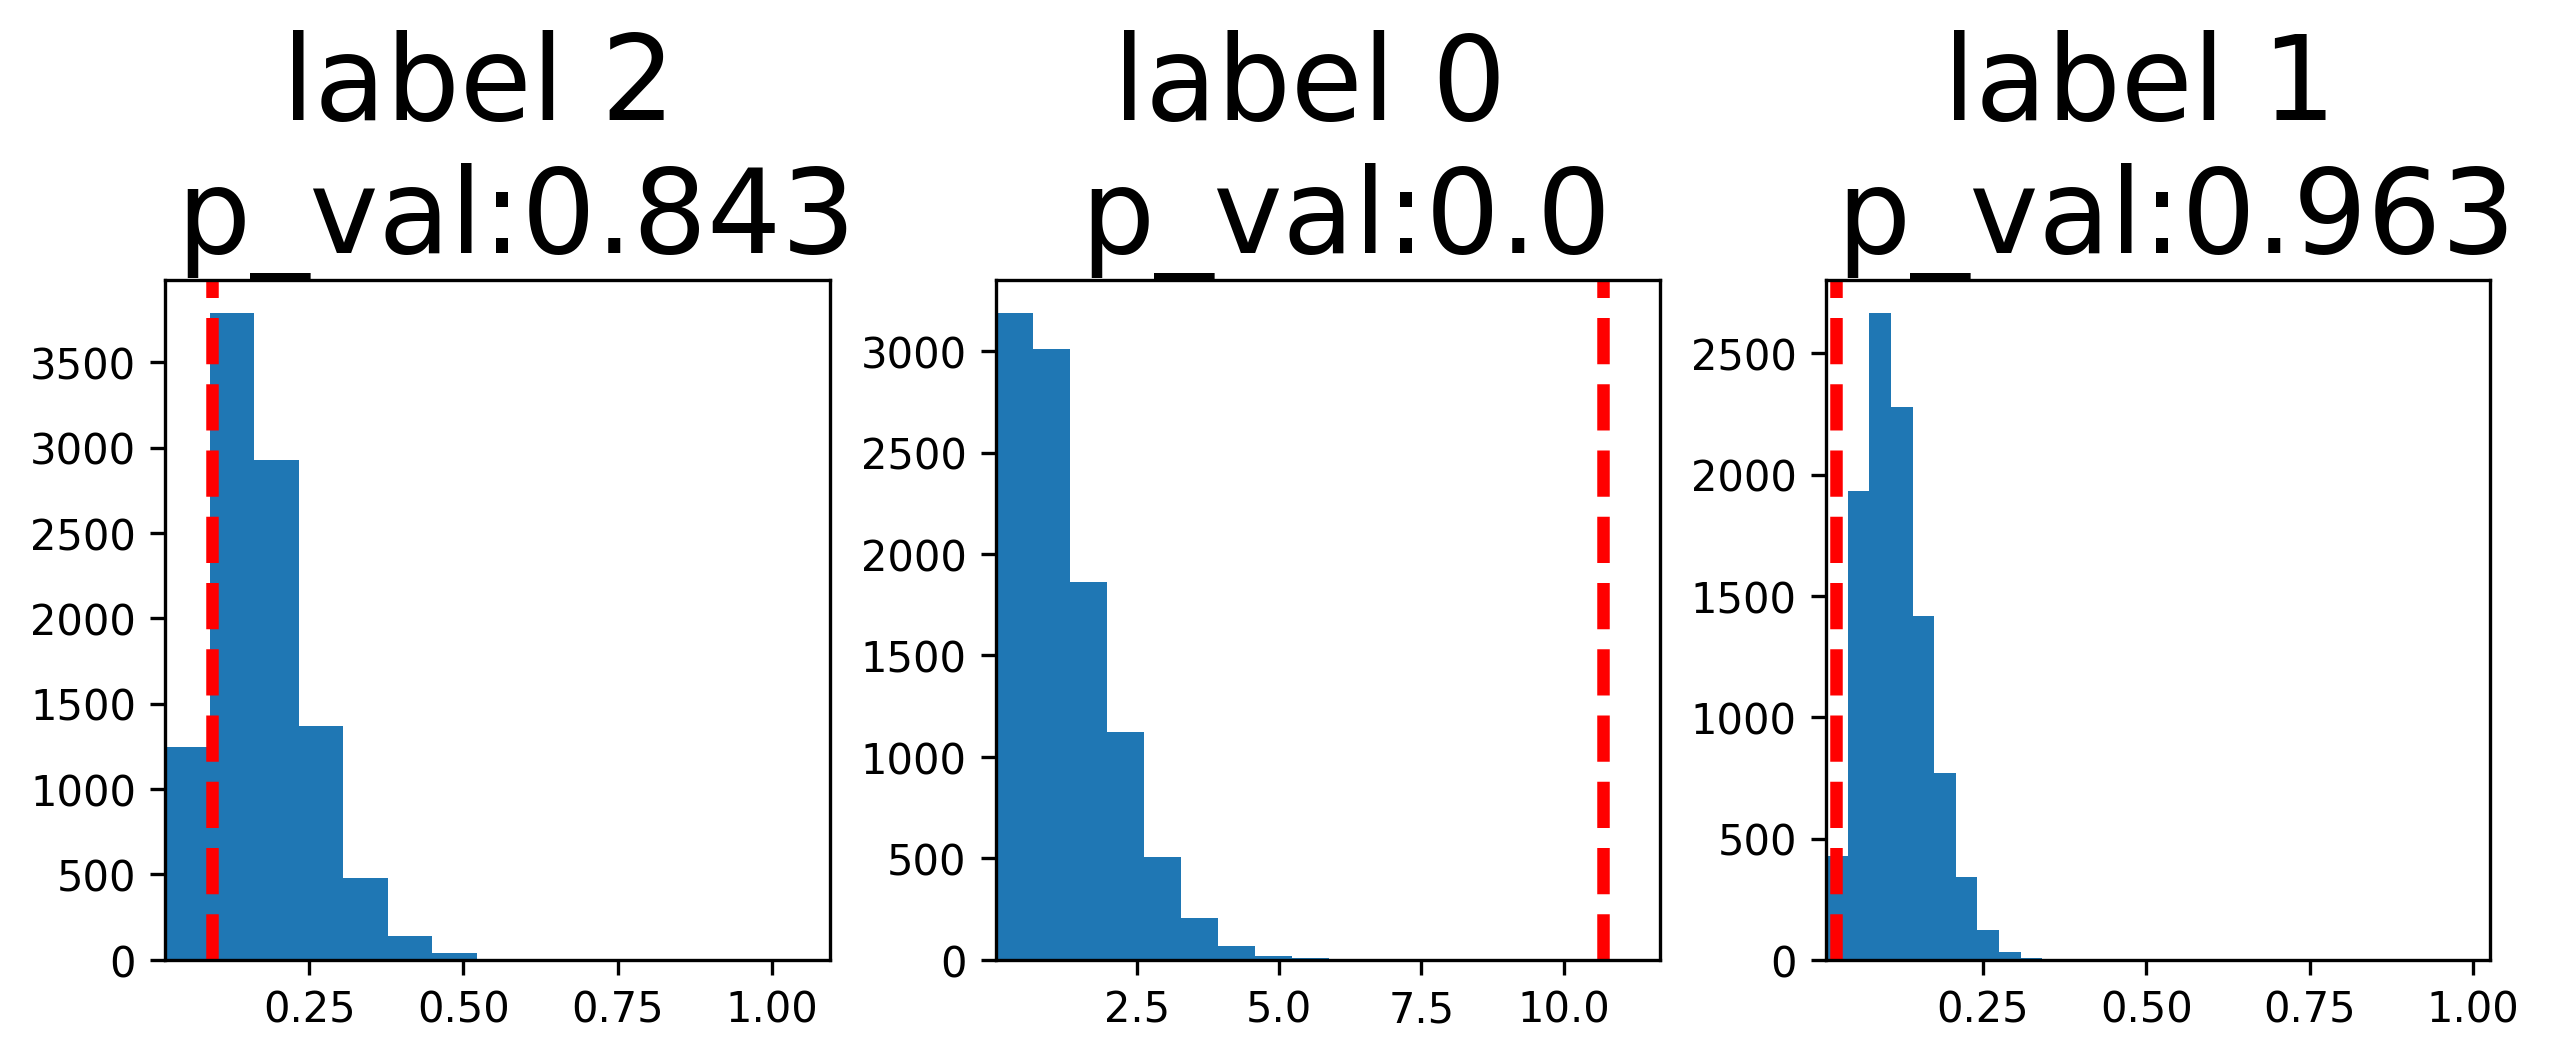

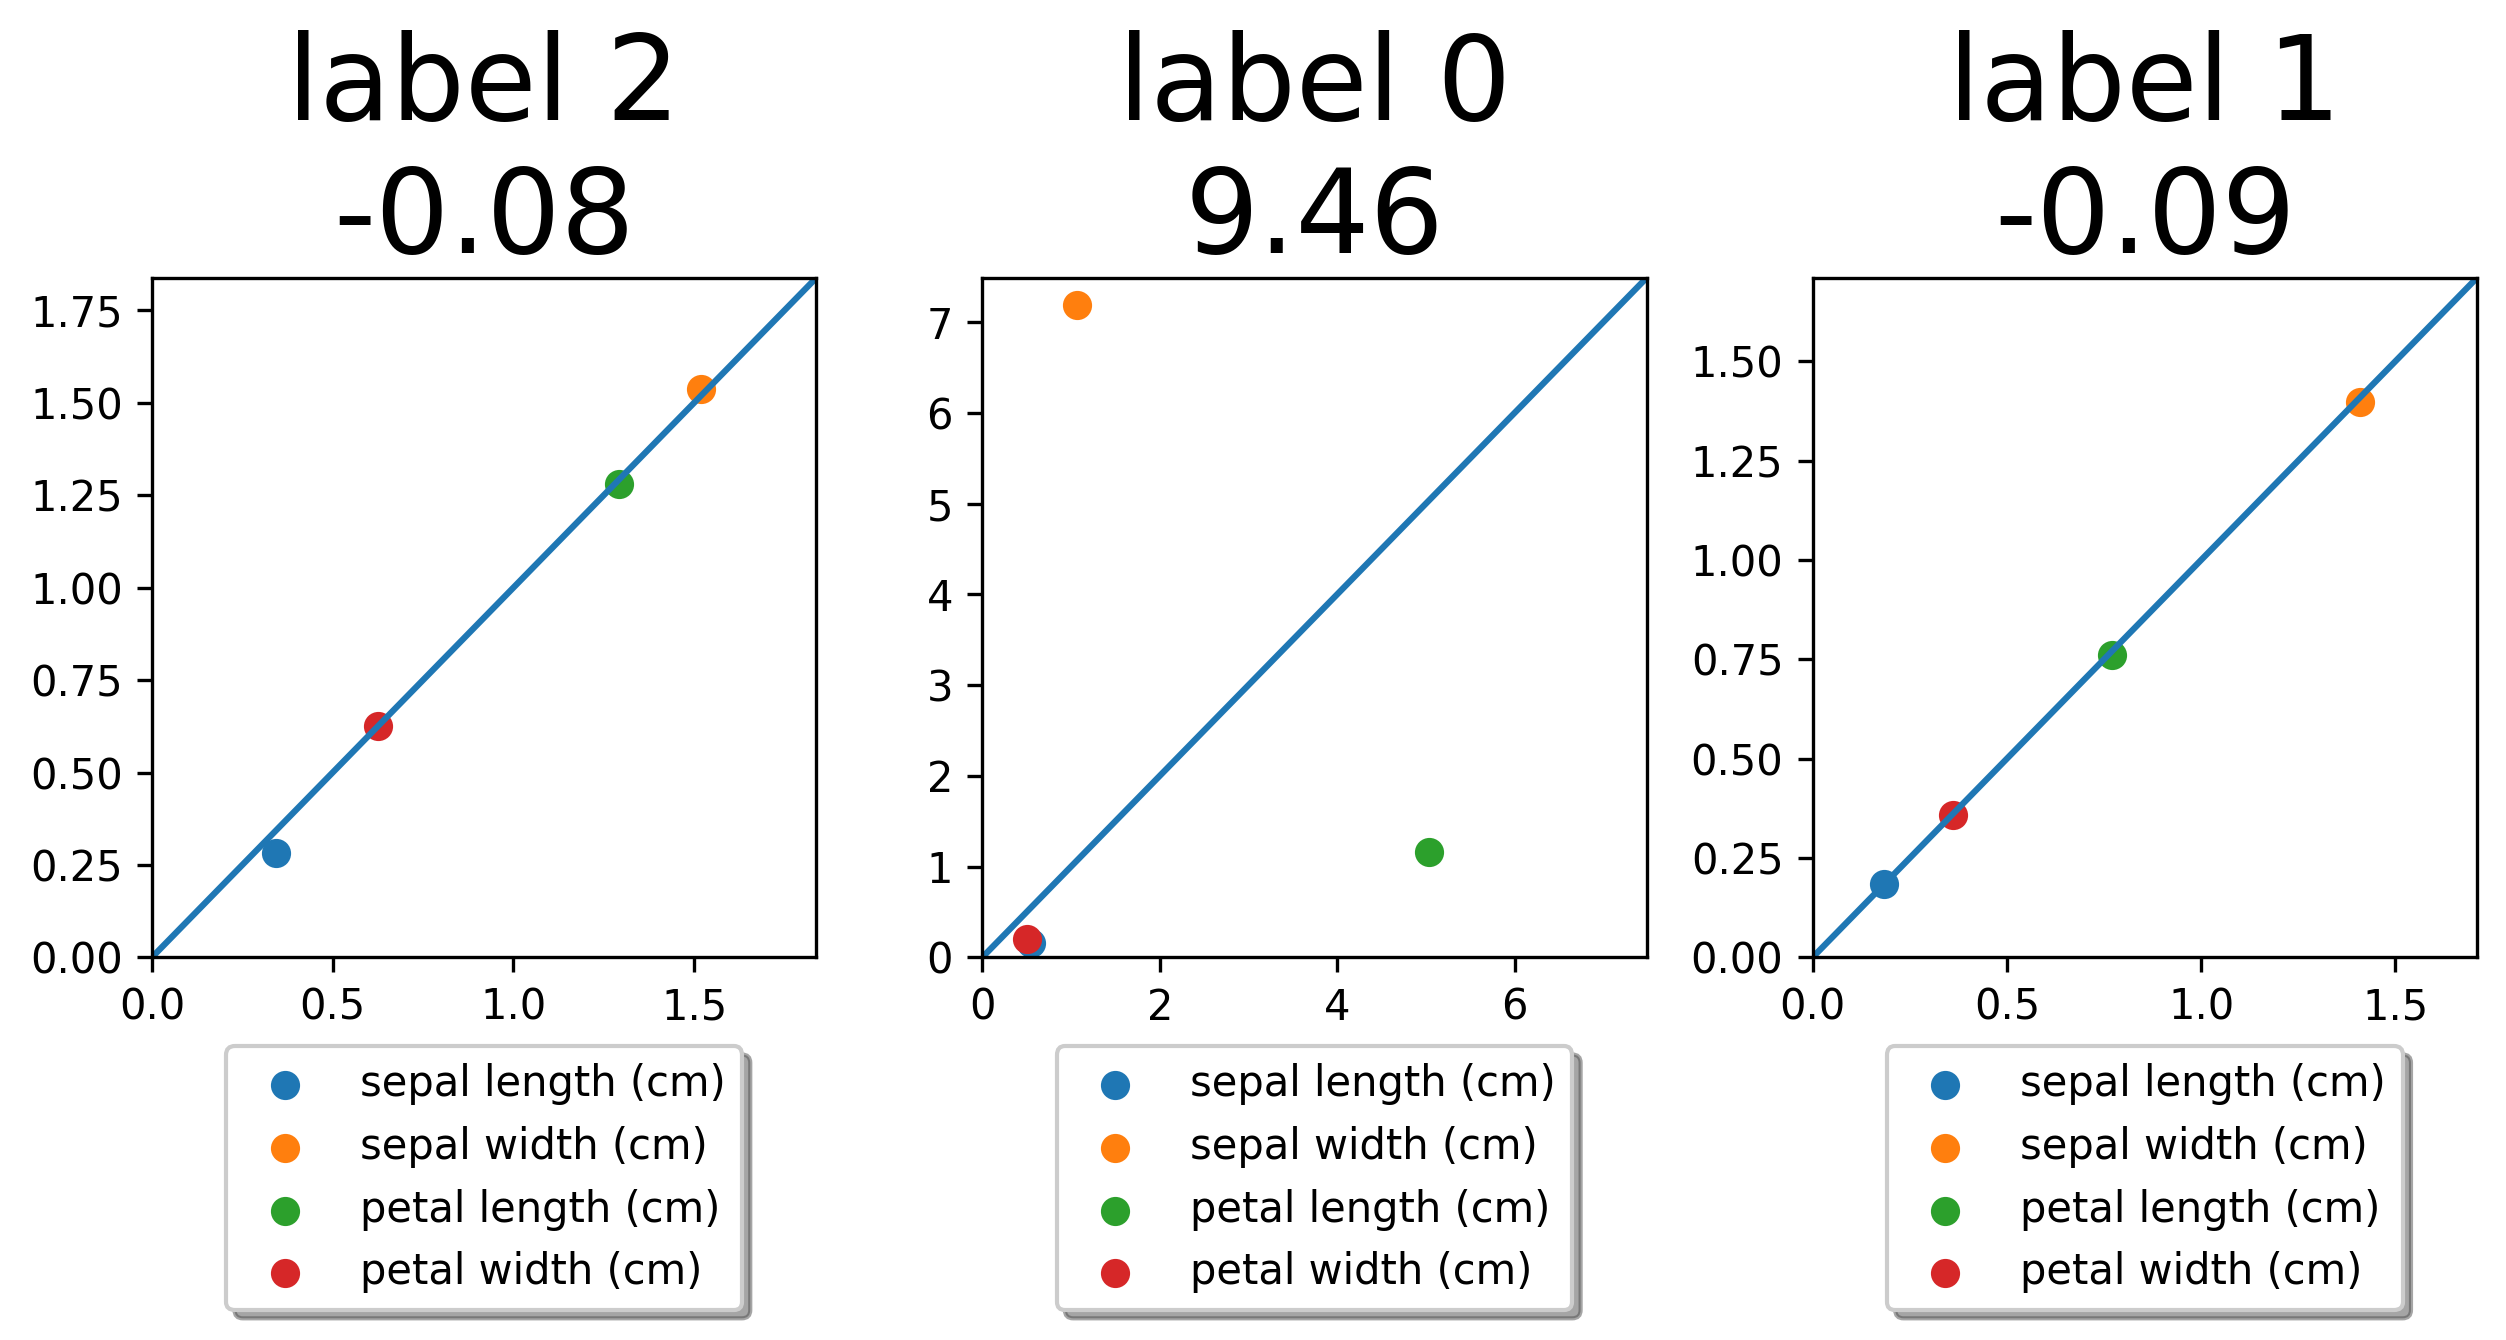

------------------------------------------------------------------------


In [73]:
G = []
type_idx = [0]
for n in type_idx:
    Batch1, Batch2, y_1, y_2 = train_test_split(X, y, test_size=0.50, random_state=5)
    noise_factor = 0.5
    print('Type : {}'.format(n))
    noise = []
    for i in range(4):
        tmp = np.random.normal(noise_factor, 0.1*noise_factor, np.sum(y_2==n))
        noise.append(tmp)
    noise = np.array(noise).T
    Batch2[y_2==n,:] += noise
   
    Combined = np.vstack((Batch1, Batch2))
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(Combined)
    
    scaler = MinMaxScaler()
    embedding = 10*scaler.fit_transform(embedding)
    
    fig, axs = plt.subplots(1,2, figsize=(7, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.2)
    axs = axs.ravel()

    fig, ax = plt.subplots(dpi=300,figsize=(5,5))
    scatter = ax.scatter(embedding[:,0],embedding[:,1],c=np.hstack((y_1,y_2))+1,cmap='tab10')
    legend1 = ax.legend(*scatter.legend_elements(),title="Flower Types")

    fig, ax = plt.subplots(dpi=300,figsize=(5,5))
    scatter = ax.scatter(embedding[:,0],embedding[:,1],c=np.array([0 for i in range(len(y_1))]+[1 for i in range(len(y_2))])+1)
    legend1 = ax.legend(*scatter.legend_elements(),title="Datasets")
    
    emb1 = embedding[:75,:]
    emb2 = embedding[75:,:]
    
    g,g2,s=umap_shap(Batch1, Batch2, y_1, y_2, emb1, emb2)
    G.append(g)
    print('------------------------------------------------------------------------')

In [74]:
G[0]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.394682,6.120876,3.874687,0.301320
1,0.001297,0.011185,0.010666,0.003194
2,0.062175,0.018426,0.011635,0.000467
